In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from functools import reduce
import operator

from common_plotting import read_data
from common_analysis import rel_data_cut_index_last, combine_stds_sum, display_full_df
from common_analysis_dcv import (analyse_dcv_absolute, analyse_dcv_relative, analyse_dcv_k182, analyse_dcv_k182_for_other_reference, add_dut_neg_and_pos_group)
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10,4)
plt.rc('font', size=14)

# Load data

In [2]:
thp_data, data = read_data(['ks3458a1-dcv-log.csv', 'ks3458a1-dcv-mv-log.csv', 'k182-dcv-mv-log.csv', 'ks3458a-dcv-log.csv'])
absolute_data_3458a_1 = data['ks3458a1-dcv-log.csv']
absolute_data_3458a_2 = data['ks3458a-dcv-log.csv']
relative_data_3458a = data['ks3458a1-dcv-mv-log.csv']
relative_data_k182 = data['k182-dcv-mv-log.csv']


# Shared functions

In [3]:
def flatten_relative_dcv_result(rel_results: pd.DataFrame, mean: float, mean_sem:float):
    rows = rel_results.apply(lambda row: {
        (row.name, 'datetime'): row.datetime,
        (row.name, 'mean'): row.mean_in_ppm - mean,
        (row.name, 'sem'): row.sem_in_ppm if mean_sem is None else (combine_stds_sum(np.array(row.sem_in_ppm, mean_sem)) if not np.isnan(row.sem_in_ppm) else np.nan),
        (row.name, 'temperature'): row.temperature,
        (row.name, 'pressure'): row.pressure,
        (row.name, 'humidity'): row.humidity
        },
        axis=1)
    return reduce(operator.ior, rows, {})

def make_abs_measurement_relative(abs_results, meter_name, abs_value=10.0):
    abs_results_without_index = abs_results.reset_index()
    rel_results = abs_results_without_index.drop(['dcv_mean', 'dcv_sem', 'dut'], axis='columns').copy()
    rel_results['mean_in_ppm'] = ((abs_value / abs_results_without_index.dcv_mean) - 1)*1e6
    rel_results['sem_in_ppm'] = abs_results_without_index.dcv_sem / abs_results_without_index.dcv_mean * 1e6
    rel_results['dut_neg_lead'] = meter_name
    rel_results['dut_pos_lead'] = abs_results_without_index.dut
    rel_results.columns = ['temperature', 'pressure', 'humidity', 'datetime', 'mean_in_ppm', 'sem_in_ppm', 'dut_neg_lead','dut_pos_lead']
    return rel_results

def get_result_from_group(result, voltage_references):
    result = pd.concat([result, pd.DataFrame([{
        'mean_in_ppm': 0,
        'sem_in_ppm': combine_stds_sum(result.sem_in_ppm.dropna()),
        'datetime': result.datetime.mean(),
        'temperature': result.temperature.mean(),
        'pressure': result.pressure.mean(),
        'humidity': result.humidity.mean(),
        }], index=['F7001bat'])])
    # results_wo_d4910avg = result[(result.index != 'D4910avg') & (result.index.isin(voltage_references))]
    # population_mean = results_wo_d4910avg.mean_in_ppm.mean()
    # if np.isnan(population_mean):
        # return None
    # population_sem = combine_stds_sum(results_wo_d4910avg.sem_in_ppm)
    # print(f"{result.datetime.mean()} mean: {population_mean}, sem: {population_sem}")
    population_mean = 0
    population_sem = None
    flat_result = flatten_relative_dcv_result(result, population_mean, population_sem)
    return flat_result


def add_pos_and_neg_dut(results, neg_dut):
    results['dut_neg_lead'] = neg_dut
    results['dut_pos_lead'] = results.index
    return results.reset_index(drop=True)


# Main analysis

In [4]:
from common_analysis import abs_data_cut_index_last


k182_rel_data_copy = relative_data_k182.copy()
k182_rel_data_copy['gap'] = k182_rel_data_copy.index.to_series().diff() > pd.Timedelta('3 hours')
k182_rel_data_copy['group'] = k182_rel_data_copy.gap.cumsum()
cut_1 = rel_data_cut_index_last(k182_rel_data_copy, 1, 'F732a2', 'D4910avg', pd.Timedelta('40 minutes'))
k182_rel_data_cut = k182_rel_data_copy[~cut_1].copy()
k182_rel_data_cut['gap'] = k182_rel_data_cut.index.to_series().diff() > pd.Timedelta('3 hours')
k182_rel_data_cut['group'] = k182_rel_data_cut.gap.cumsum()

ag3458a_rel_data = relative_data_3458a.copy()
ag3458a_rel_data['gap'] = ag3458a_rel_data.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_rel_data['group'] = ag3458a_rel_data.gap.cumsum()

ag3458a_1_abs_data = absolute_data_3458a_1.copy()
ag3458a_1_abs_data['gap'] = ag3458a_1_abs_data.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_1_abs_data['group'] = ag3458a_1_abs_data.gap.cumsum()
cut_1 = abs_data_cut_index_last(ag3458a_1_abs_data, 2, 'D4910avg', '10 V', pd.Timedelta('4 minutes'), pd.Timestamp('2021-11-17T21:38:19'))
cut_2 = (ag3458a_1_abs_data.index > pd.Timestamp('2021-11-17T23:49:12')) & (ag3458a_1_abs_data.index < pd.Timestamp('2022-04-18T21:35:20'))
cut_3 = (ag3458a_1_abs_data.index > pd.Timestamp('2022-04-19T02:11:40')) & (ag3458a_1_abs_data.index < pd.Timestamp('2022-08-09T22:49:55'))
cut_4 = ~(ag3458a_1_abs_data.dut_setting.isin(['-10 V', '10 V']))
ag3458a_1_abs_data_cut = ag3458a_1_abs_data[~cut_1 & ~cut_2 & ~cut_3 & ~cut_4].copy()
ag3458a_1_abs_data_cut['gap'] = ag3458a_1_abs_data_cut.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_1_abs_data_cut['group'] = ag3458a_1_abs_data_cut.gap.cumsum()

cut_1 = (absolute_data_3458a_2.index > pd.Timestamp('2021-09-10T10:08:00')) & (absolute_data_3458a_2.index < pd.Timestamp('2021-09-12T22:17:24'))
cut_2 = ~(absolute_data_3458a_2.dut_setting.isin(['-10 V', '10 V']))
ag3458a_2_abs_data = absolute_data_3458a_2[~cut_1 & ~cut_2].copy()
ag3458a_2_abs_data['gap'] = ag3458a_2_abs_data.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_2_abs_data['group'] = ag3458a_2_abs_data.gap.cumsum()

In [5]:
voltage_references = ('F732a1', 'F732a2', 'F732a3', 'D4910avg', 'D4910-1', 'D4910-2', 'D4910-3', 'D4910-4', 'F7001bat')
columns = [(dut, param) for dut in voltage_references for param in ('datetime', 'mean', 'sem', 'temperature', 'pressure', 'humidity')]
results = []
for group in ag3458a_1_abs_data_cut.group.unique():
    group_samples = ag3458a_1_abs_data_cut[ag3458a_1_abs_data_cut.group == group].copy()
    abs_result, _ = analyse_dcv_absolute(group_samples.drop('group', axis=1), 'F7001bat', 'ag3458a_1', with_pressure_and_humidity=True)
    rel_result = make_abs_measurement_relative(abs_result, 'ag3458a_1')
    display(rel_result)
for group in ag3458a_2_abs_data.group.unique():
    group_samples = ag3458a_2_abs_data[ag3458a_2_abs_data.group == group].copy()
for group in ag3458a_rel_data.group.unique():
    group_samples = ag3458a_rel_data[ag3458a_rel_data.group == group].copy()
    result = analyse_dcv_relative(group_samples, 'F7001bat', 10, 'F7001bat', 'ag3458a_1', 0)
    flat_result = get_result_from_group(result, voltage_references)
    if flat_result is None:
        continue
    results.append(flat_result)
for group in k182_rel_data_cut.group.unique():
    group_samples = k182_rel_data_cut[k182_rel_data_cut.group == group].copy()
    result = analyse_dcv_k182(group_samples)
    result_with_pos_and_neg_dut = add_pos_and_neg_dut(result, 'F7001bat')
#     display(result_with_pos_and_neg_dut)
    flat_result = get_result_from_group(result, voltage_references)
    if flat_result is None:
        continue
    results.append(flat_result)
orig_max_cols = pd.get_option('display.max_columns')
rel_results = pd.DataFrame(results, columns=pd.MultiIndex.from_tuples(columns))
pd.set_option('display.max_columns', None)
display(rel_results)
pd.set_option('display.max_columns', orig_max_cols)

,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,33.038991,1019.782891,34.271891,2021-09-13 01:16:11.106514432,-1.049799,0.008031,ag3458a_1,D4910avg


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,30.601058,1027.110595,29.689673,2021-11-15 12:20:37.823304448,-0.540429,0.003639,ag3458a_1,D4910avg


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,27.851310,1025.779504,30.444915,2021-11-17 21:47:34.621198848,-0.656465,0.012114,ag3458a_1,D4910-1
1,27.956858,1025.803233,30.438114,2021-11-17 21:56:25.799262720,-0.599653,0.010989,ag3458a_1,D4910-2
2,28.025066,1025.809169,30.468637,2021-11-17 22:06:19.654903296,-1.010775,0.005371,ag3458a_1,D4910-3
3,28.162754,1026.014973,30.437063,2021-11-17 22:18:33.809083904,-0.440197,0.012676,ag3458a_1,D4910-4
4,28.214252,1025.990268,30.468563,2021-11-17 22:36:28.794583296,-0.580659,0.008679,ag3458a_1,D4910avg
5,28.463376,1026.001442,30.361762,2021-11-17 22:52:12.771252736,5.000503,0.010141,ag3458a_1,F7001
6,28.645491,1026.086342,30.483541,2021-11-17 23:45:17.736522752,4.972798,0.008798,ag3458a_1,F7001bat
7,28.483960,1026.066401,30.391553,2021-11-17 23:00:48.476329728,-18.012649,0.008470,ag3458a_1,F732a1
8,28.596207,1026.174995,30.396268,2021-11-17 23:23:39.279436288,-128.492405,0.226992,ag3458a_1,F732a2
9,28.537036,1026.113433,30.371473,2021-11-17 23:10:47.794051840,21.141809,0.009433,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,32.112881,1015.842193,23.591878,2022-04-19 01:18:05.016456448,-0.896095,0.007296,ag3458a_1,D4910-1
1,32.124529,1015.756467,23.581296,2022-04-19 01:29:44.294131456,-0.710347,0.017469,ag3458a_1,D4910-2
2,32.116193,1015.724833,23.551472,2022-04-19 01:39:38.503834112,-1.226322,0.011713,ag3458a_1,D4910-3
3,32.095335,1015.697843,23.631803,2022-04-19 01:49:13.145952256,-0.196735,0.008317,ag3458a_1,D4910-4
4,31.825900,1016.170369,23.812824,2022-04-18 23:54:39.372254976,-0.709954,0.011118,ag3458a_1,D4910avg
5,32.068434,1016.329502,23.714892,2022-04-18 23:39:19.421422592,5.070017,0.010267,ag3458a_1,F7001
6,31.192047,1016.495127,24.446800,2022-04-18 22:05:07.110281728,-18.340083,0.009324,ag3458a_1,F732a1
7,31.567563,1016.439728,24.153382,2022-04-18 22:20:03.121816320,-15.775134,0.006596,ag3458a_1,F732a2
8,32.082643,1016.155638,23.756762,2022-04-19 00:33:21.472284672,22.404520,0.009009,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,35.187786,1028.105504,30.813919,2022-08-10 00:12:08.768655360,-1.284911,0.007100,ag3458a_1,D4910-1
1,35.651870,1028.139486,30.196302,2022-08-10 00:26:01.495332608,-2.702958,0.577549,ag3458a_1,D4910-2
2,35.537879,1028.248602,30.194592,2022-08-10 00:40:04.676518912,-1.283399,0.012532,ag3458a_1,D4910-3
3,35.175105,1028.216810,30.825718,2022-08-10 00:51:50.824821760,-0.579493,0.008066,ag3458a_1,D4910-4
4,35.229821,1028.176042,30.901842,2022-08-10 00:05:58.184820480,-0.984777,0.006623,ag3458a_1,D4910avg
5,34.733334,1028.237509,31.754131,2022-08-09 22:53:55.430031872,5.218917,0.007321,ag3458a_1,F7001
6,35.001955,1028.227397,31.503022,2022-08-09 23:51:58.256628992,5.231551,0.005226,ag3458a_1,F7001bat
7,34.947451,1028.079614,31.313529,2022-08-09 23:56:54.761939456,-18.623179,0.005498,ag3458a_1,F732a1
8,35.229418,1028.187422,30.959586,2022-08-09 23:34:32.859304192,-15.920430,0.009969,ag3458a_1,F732a2
9,34.957188,1028.092624,31.333761,2022-08-09 23:44:43.311764480,22.719325,0.007029,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,39.528246,1017.098574,32.501549,2022-08-12 23:48:59.910887936,-1.667449,0.005528,ag3458a_1,D4910-1
1,39.543780,1017.044494,32.681422,2022-08-13 00:01:10.540229120,-1.341704,0.005882,ag3458a_1,D4910-2
2,39.545984,1017.061895,32.942361,2022-08-13 00:11:33.863774720,-1.928960,0.004961,ag3458a_1,D4910-3
3,39.564533,1017.104393,33.138705,2022-08-13 00:20:39.299576320,-1.217418,0.005342,ag3458a_1,D4910-4
4,39.556059,1017.112210,32.948281,2022-08-13 00:34:37.811014656,-1.480108,0.004910,ag3458a_1,D4910avg
5,39.578576,1017.025515,33.018729,2022-08-13 00:37:12.183028992,4.887614,0.006072,ag3458a_1,F7001bat
6,39.548461,1017.221161,33.317355,2022-08-13 00:44:20.082441216,-18.965473,0.007705,ag3458a_1,F732a1
7,39.500840,1017.076983,33.088182,2022-08-13 01:08:20.906902528,-16.384582,0.068823,ag3458a_1,F732a2
8,39.520713,1017.110603,33.191648,2022-08-13 00:56:47.217241856,22.528961,0.006273,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,28.931833,1013.807649,45.220087,2022-08-18 21:38:10.554818816,5.361854,0.002732,ag3458a_1,F7001


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,37.726087,1015.357075,28.457792,2022-08-25 11:16:58.605532160,-0.959384,0.008104,ag3458a_1,D4910-1
1,37.556162,1015.337579,29.142990,2022-08-25 11:23:20.912476416,-0.707776,0.006414,ag3458a_1,D4910-2
2,37.427600,1015.323666,29.091629,2022-08-25 11:32:01.782985984,-1.098352,0.005921,ag3458a_1,D4910-3
3,37.209281,1015.267464,29.741619,2022-08-25 11:43:54.452855040,-0.325726,0.006939,ag3458a_1,D4910-4
4,38.845250,1014.717923,27.939263,2022-08-25 13:54:03.075288832,-0.499485,0.004810,ag3458a_1,D4910avg
5,39.408432,1014.524304,27.187581,2022-08-25 14:35:15.091242752,35.947456,15.689534,ag3458a_1,F7001bat
6,37.831020,1015.067816,28.983762,2022-08-25 12:19:06.570497536,-18.074141,0.006664,ag3458a_1,F732a1
7,38.078704,1014.987431,28.404468,2022-08-25 12:29:39.829271552,-12.351299,0.080992,ag3458a_1,F732a2
8,38.002569,1014.943660,28.616488,2022-08-25 12:31:38.254687488,23.319179,0.005506,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,36.797675,1022.993976,23.952843,2022-08-29 13:23:32.518631680,-1.017728,0.007057,ag3458a_1,D4910-1
1,37.139390,1022.922406,23.510724,2022-08-29 13:38:51.382781440,-0.750972,0.007177,ag3458a_1,D4910-2
2,37.340805,1022.831808,23.171719,2022-08-29 13:50:12.182699776,-1.113744,0.006265,ag3458a_1,D4910-3
3,37.415271,1022.736650,23.487879,2022-08-29 14:15:20.917244416,-0.194672,0.007848,ag3458a_1,D4910-4
4,37.159561,1022.830344,23.729239,2022-08-29 13:44:54.191993344,-0.918702,0.022240,ag3458a_1,D4910avg
5,37.100718,1022.898712,23.793342,2022-08-29 13:30:54.116468992,5.624715,0.007231,ag3458a_1,F7001bat
6,37.782947,1022.422931,23.031179,2022-08-29 14:55:20.678319616,-18.255417,0.005618,ag3458a_1,F732a1
7,37.521192,1022.573777,23.694677,2022-08-29 14:39:48.001377792,-15.572154,0.007010,ag3458a_1,F732a2
8,37.333237,1022.682643,23.934145,2022-08-29 14:25:59.754595840,23.090694,0.005791,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,30.954798,1015.402289,31.454428,2022-09-24 20:10:50.766003200,-0.991028,0.000846,ag3458a_1,D4910-1
1,31.595548,1016.798242,28.352573,2022-09-23 05:28:42.548478976,-0.737716,0.000788,ag3458a_1,D4910-2
2,31.234924,1013.907902,31.934428,2022-09-23 18:56:57.453813248,-0.950146,0.000689,ag3458a_1,D4910-3
3,31.229889,1012.092535,32.146929,2022-09-24 06:56:08.617316352,-0.123335,0.000597,ag3458a_1,D4910-4
4,30.738129,1016.543814,30.678744,2022-09-25 07:31:30.401962496,-0.562940,0.001527,ag3458a_1,D4910avg
5,30.724727,1005.292910,30.325412,2022-09-26 05:10:50.433551872,-18.508711,0.000862,ag3458a_1,F732a1
6,31.476375,1024.234958,28.259621,2022-09-22 04:50:38.039378432,-15.815717,0.001138,ag3458a_1,F732a2
7,32.441882,1021.148329,28.009771,2022-09-22 15:28:30.943258368,23.097921,0.001694,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,28.299414,1013.229575,34.695872,2022-12-25 02:30:16.490373632,6.164606,0.008428,ag3458a_1,F7001bat


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,25.957977,1034.357016,27.460832,2023-01-22 02:45:16.536414208,-0.615681,0.008372,ag3458a_1,D4910-1
1,25.814478,1034.325875,27.756776,2023-01-22 02:51:42.502478848,-0.426232,0.005704,ag3458a_1,D4910-2
2,25.717659,1034.329113,27.975979,2023-01-22 02:56:26.215889408,-0.685482,0.006746,ag3458a_1,D4910-3
3,25.723997,1034.321634,28.039411,2023-01-22 03:00:16.029763072,0.466407,0.007662,ag3458a_1,D4910-4
4,25.556520,1034.561977,26.927693,2023-01-22 02:09:51.177352960,-0.220917,0.005766,ag3458a_1,D4910avg
5,25.647694,1034.359362,28.062571,2023-01-22 02:37:31.826261504,5.955086,0.006854,ag3458a_1,F7001bat
6,25.288402,1034.691678,26.908588,2023-01-22 01:50:32.780142080,-18.478039,0.004788,ag3458a_1,F732a1
7,25.804695,1034.516671,27.997904,2023-01-22 02:24:40.939132928,-15.659397,0.003686,ag3458a_1,F732a2
8,25.429512,1034.689192,27.427270,2023-01-22 01:58:17.765229056,23.583751,0.004878,ag3458a_1,F732a3


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,32.946650,1013.902668,28.825978,2023-07-16 20:36:52.838592768,728.533860,0.069040,ag3458a_1,AD587JQ-1
1,33.525441,1014.034945,30.496044,2023-07-16 21:35:12.423237632,-196.491184,12.953711,ag3458a_1,AD587JQ-10
2,33.519682,1014.093655,30.538340,2023-07-16 21:41:11.831094272,-195.053373,0.063351,ag3458a_1,AD587JQ-11
3,33.560813,1014.148627,30.447446,2023-07-16 21:47:01.436719616,-1237.190867,48.838451,ag3458a_1,AD587JQ-12
4,33.956742,1014.214971,30.199649,2023-07-16 21:54:30.850829312,-177.960644,0.959406,ag3458a_1,AD587JQ-13
5,34.054242,1014.245317,30.028165,2023-07-16 21:58:42.127662592,-32.325493,0.074597,ag3458a_1,AD587JQ-14
6,34.089720,1014.272315,30.025350,2023-07-16 22:03:09.603807744,-179.019410,0.083580,ag3458a_1,AD587JQ-15
7,34.283080,1014.351758,29.684628,2023-07-16 22:26:33.307627776,155.963749,0.032526,ag3458a_1,AD587JQ-16
8,34.263300,1014.354752,29.710303,2023-07-16 22:31:54.149485312,-318.659567,0.184212,ag3458a_1,AD587JQ-17
9,34.260933,1014.332681,29.904203,2023-07-16 22:36:49.149692416,-1879.050731,186.055669,ag3458a_1,AD587JQ-18


,temperature,pressure,humidity,datetime,mean_in_ppm,sem_in_ppm,dut_neg_lead,dut_pos_lead
0,35.871398,1020.955085,34.14937,2023-08-22 23:18:15.124054784,5.86376,0.006628,ag3458a_1,F7001bat


F732a1                                   \
                        datetime       mean       sem temperature   
0  2022-08-10 02:42:04.326365952  23.982641  0.002508   34.877467   
1  2022-08-25 11:22:17.590431744  23.826725  0.002438   37.619157   
2                            NaT        NaN       NaN         NaN   
3  2022-08-29 14:37:56.017542400  23.974241  0.000651   37.508195   
4  2022-09-21 15:20:56.923994624  24.045509  0.003566   31.926506   
5  2022-12-22 21:38:08.994086400  24.187865  0.003949   27.895061   
6  2023-01-14 18:56:41.392179712  24.475947  0.003604   25.945197   
7  2023-01-22 01:19:35.432957440  24.329748  0.004085   24.418316   
8  2023-01-25 22:41:22.304952832  24.410736  0.004745   25.170996   
9                            NaT        NaN       NaN         NaN   
10 2023-01-27 23:36:17.341893120  24.296323  0.003345   28.350979   
11                           NaT        NaN       NaN         NaN   
12 2023-01-28 15:07:23.155353088  24.389536  0.003931   31.665460   
13 2023-03-02 01:59:41.804903168  24.329724  0.003806   28.327617   
14 2023-06-24 21:42:10.059316224  24.702066  0.003318   32.858124   
15 2023-07-16 20:50:56.948048384  24.812144  0.002518   33.153038   
16 2023-07-22 23:25:36.147859968  24.889152  0.003867   33.801844   
17 2023-08-22 21:52:32.337179136  24.948169  0.003841   33.623643   

                                                  F732a2                       \
       pressure   humidity                      datetime       mean       sem   
0   1027.884677  31.436515 2022-08-10 03:01:26.240461824  21.272298  0.003114   
1   1015.337532  28.855276 2022-08-25 11:38:27.978521344  21.109801  0.003885   
2           NaN        NaN                           NaT        NaN       NaN   
3   1022.579408  23.654013 2022-08-29 13:43:49.964445696  21.322970  0.000814   
4   1026.429435  22.709645 2022-09-21 15:28:52.841974784  21.394095  0.003241   
5   1002.113863  33.452271 2022-12-22 21:34:38.862407168  21.430439  0.004298   
6    995.474800  36.025571 2023-01-14 18:53:07.648848896  21.669566  0.004221   
7   1034.795595  27.565945 2023-01-22 01:24:01.665231104  21.589683  0.001685   
8   1025.835012  26.277449 2023-01-26 00:26:54.946850304  21.577355  0.008860   
9           NaN        NaN 2023-01-26 08:23:30.832382208  21.546582  0.007190   
10  1030.047550  27.095842 2023-01-27 23:28:51.173477376  21.578546  0.004598   
11          NaN        NaN 2023-01-28 06:06:57.842015232  21.544061  0.005398   
12  1030.152193  25.268042 2023-01-28 15:03:11.508902912  21.590940  0.005300   
13  1025.493539  22.894800 2023-03-02 01:56:20.820233728  21.535209  0.004686   
14  1021.945571  33.201811 2023-06-24 21:35:13.448096768  21.830229  0.004468   
15  1013.870446  30.129140 2023-07-16 20:44:57.703027456  21.917490  0.002956   
16  1009.919901  32.507132 2023-07-22 23:30:20.788241408  21.912764  0.003170   
17  1020.986121  36.137863 2023-08-22 21:44:54.597615104  21.794057  0.003616   

                                                              F732a3  \
   temperature     pressure   humidity                      datetime   
0    34.819442  1027.887984  31.265190 2022-08-10 02:51:34.409591808   
1    37.677573  1015.255665  28.696644 2022-08-25 11:44:08.448907520   
2          NaN          NaN        NaN                           NaT   
3    37.120882  1022.884395  23.581948 2022-08-29 11:25:53.247917056   
4    32.455406  1026.352040  21.831325 2022-09-21 15:24:50.224551680   
5    27.719199  1002.049425  33.660435 2022-12-22 21:42:19.887340032   
6    25.936919   995.468495  35.979581 2023-01-14 18:50:16.263861248   
7    24.285600  1034.790586  27.475825 2023-01-22 01:36:55.545875712   
8    24.652354  1025.155756  25.828323 2023-01-26 00:12:51.405470720   
9    26.475819  1025.229465  28.487566 2023-01-26 08:25:27.378796032   
10   28.508733  1030.139306  26.883538 2023-01-27 23:32:20.678178304   
11   28.210090  1030.512973  27.087796 2023-01-28 06:09:22.856514560   
12   31.562729  

## All references relative to F7001

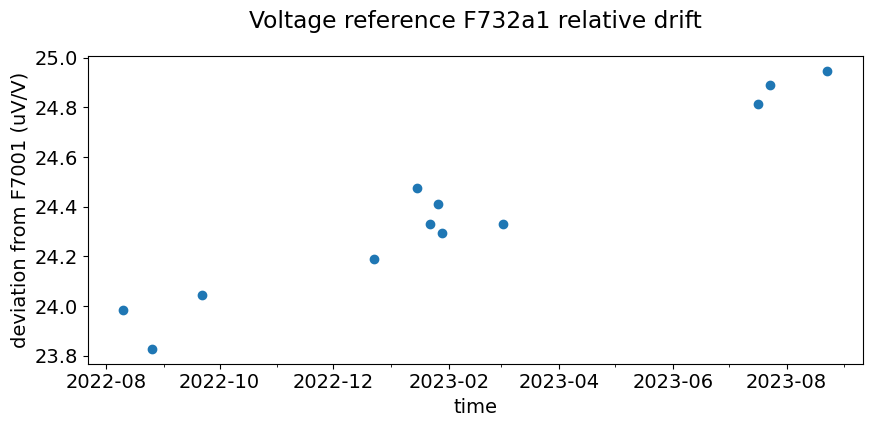

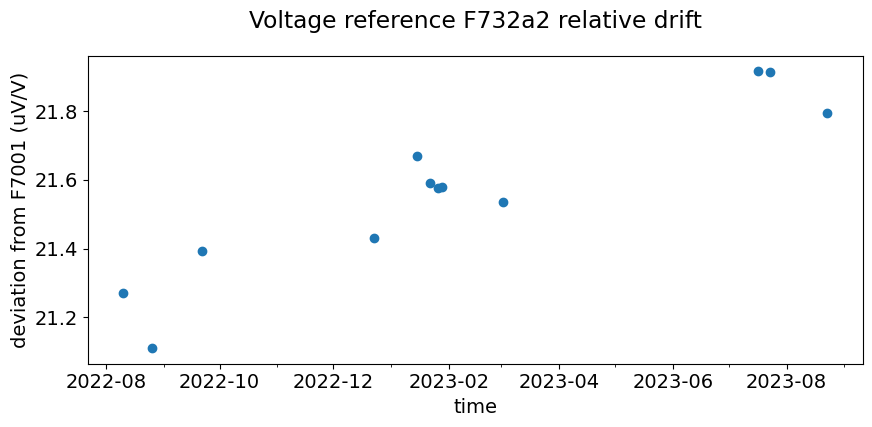

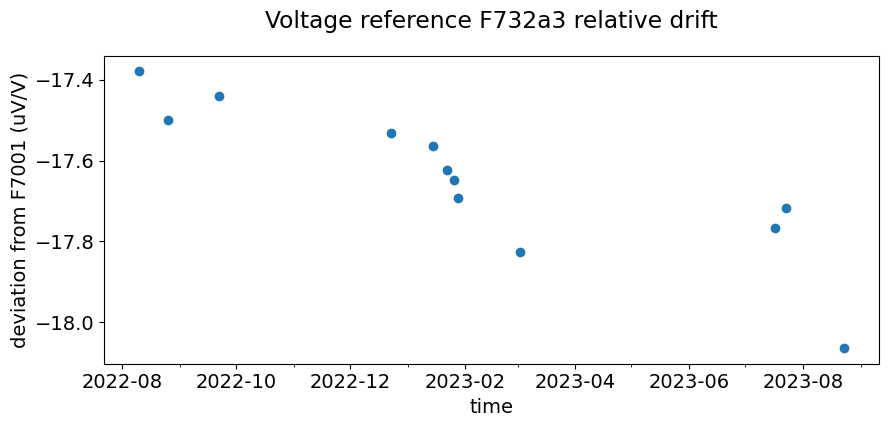

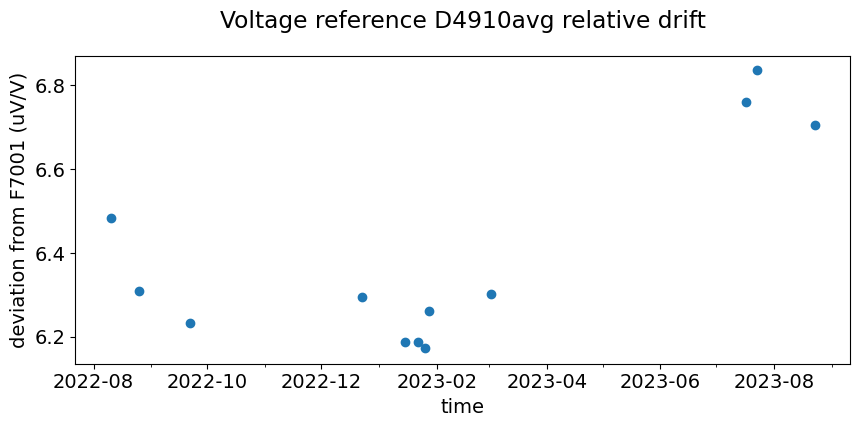

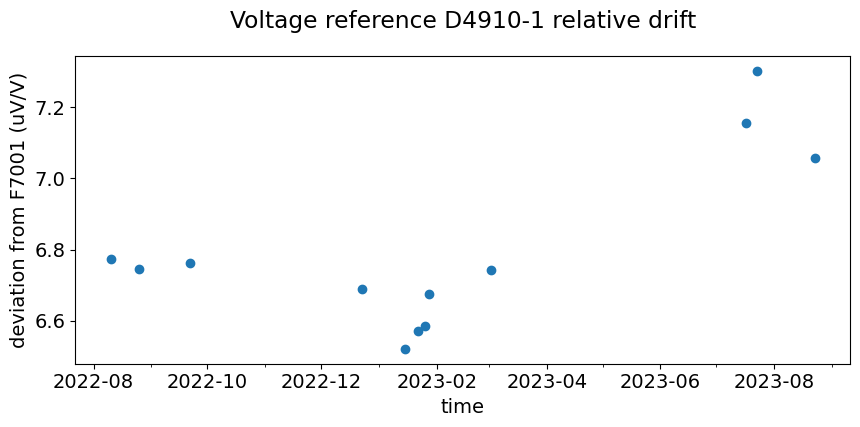

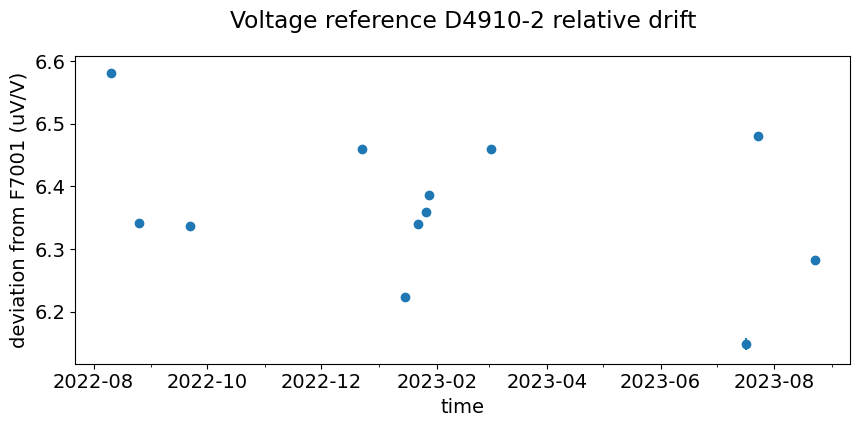

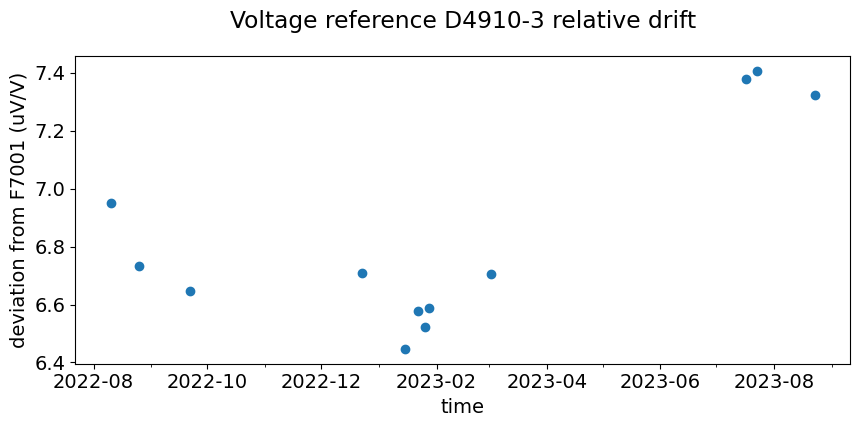

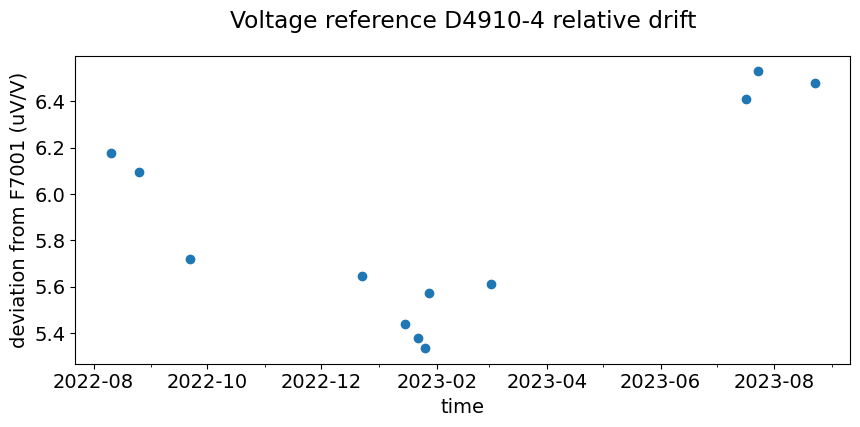

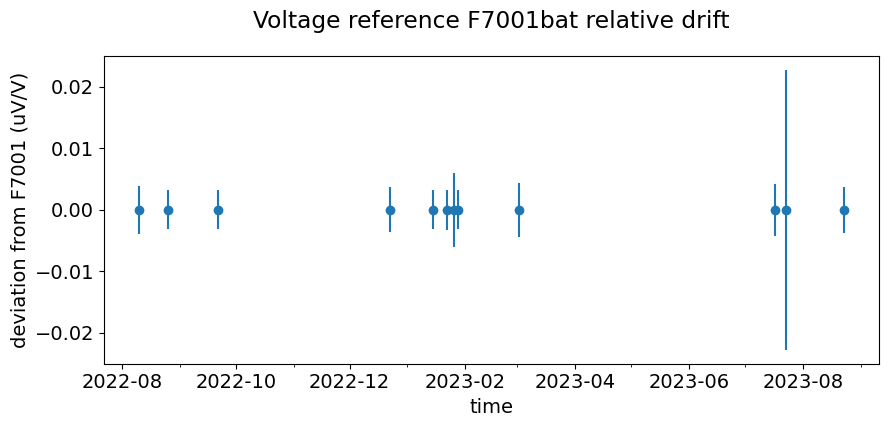

In [6]:
plt.rcParams["figure.figsize"] = (10,4)

# rel_results[[(ref, param) for ref in voltage_references for param in ('mean', 'sem', 'datetime')]]
rel_results = rel_results.dropna()
for ref in voltage_references:  
    plt.errorbar(rel_results[(ref, 'datetime')].dropna(), rel_results[(ref, 'mean')].dropna(), yerr=rel_results[(ref, 'sem')].dropna(), label=ref, fmt='o')
    plt.xlabel('time')
    plt.ylabel('deviation from F7001 (uV/V)')
    plt.title(f'Voltage reference {ref} relative drift', pad=20)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    plt.show()

## D4910 cells relative to D4910avg (based on measurements against F7001)

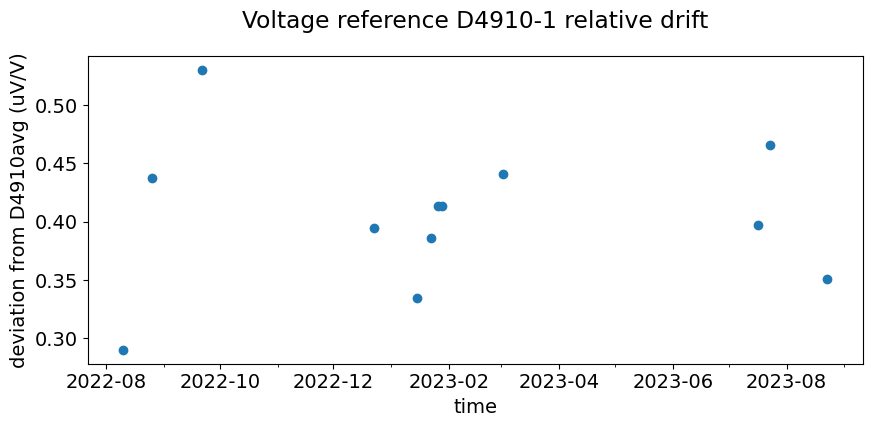

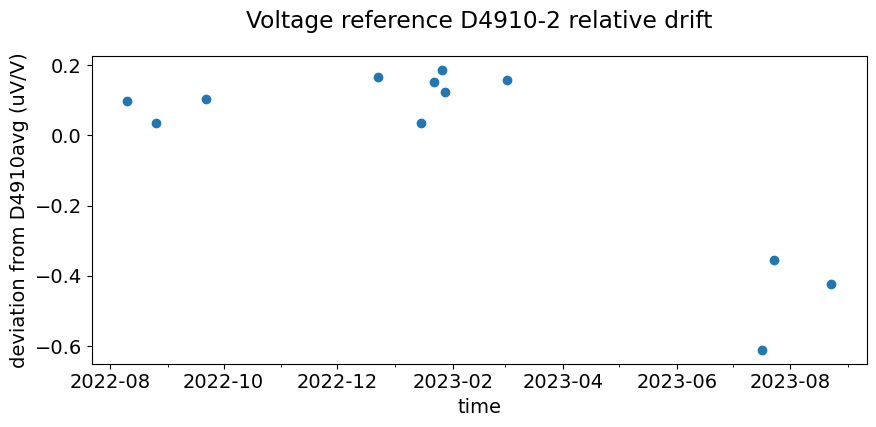

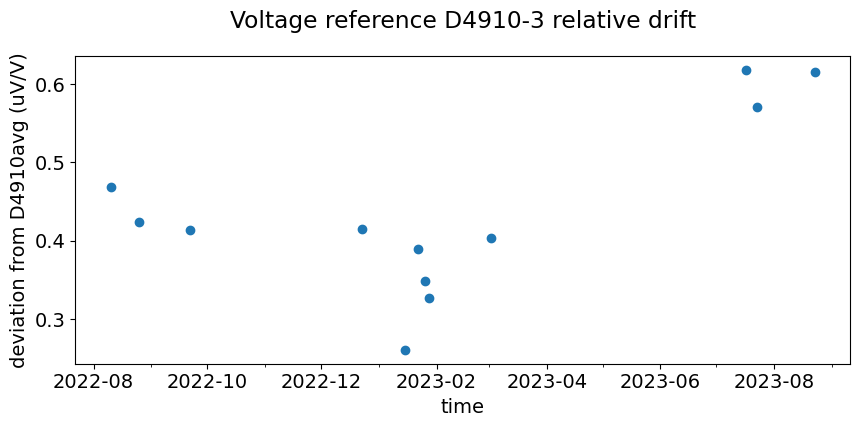

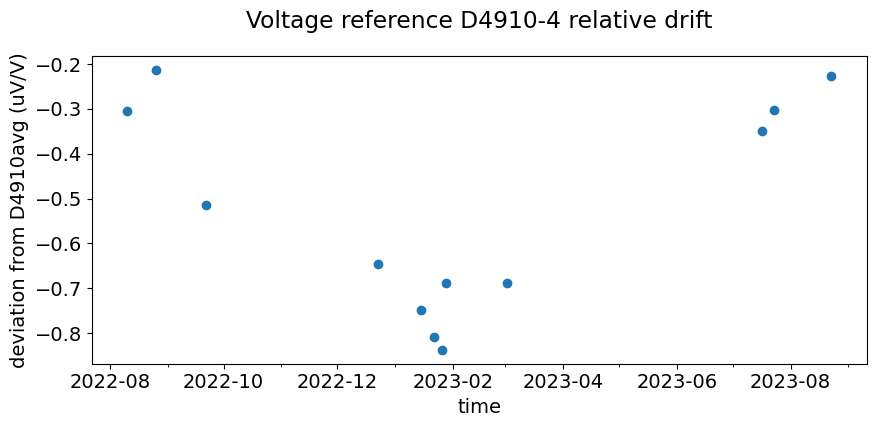

In [7]:
plt.rcParams["figure.figsize"] = (10,4)

# rel_results[[(ref, param) for ref in voltage_references for param in ('mean', 'sem', 'datetime')]]
rel_results = rel_results.dropna()
for ref in voltage_references:
    if not ref.startswith('D4910-'):
        continue
    dates = rel_results[(ref, 'datetime')]
    means = rel_results[(ref, 'mean')]
    D4910_date_index = pd.DatetimeIndex(rel_results[('D4910avg', 'datetime')])
    D4910_indices = D4910_date_index.get_indexer(dates, method='nearest', tolerance=pd.Timedelta('1 day'))
    D4910_values = rel_results[('D4910avg', 'mean')].iloc[D4910_indices]
    results_relative_to_D4910avg = means - D4910_values
    plt.scatter(rel_results[(ref, 'datetime')].dropna(), results_relative_to_D4910avg.dropna(), label=ref)
    plt.xlabel('time')
    plt.ylabel('deviation from D4910avg (uV/V)')
    plt.title(f'Voltage reference {ref} relative drift', pad=20)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    plt.show()

## D4910 cells relative to D4910avg (based on measurements against D4910avg)

In [24]:
voltage_references = ('D4910-1', 'D4910-2', 'D4910-3', 'D4910-4')
columns = [(dut, param) for dut in voltage_references for param in ('datetime', 'mean', 'sem', 'temperature', 'pressure', 'humidity')]
results = []
for group in k182_rel_data_cut.group.unique():
    group_samples = k182_rel_data_cut[k182_rel_data_cut.group == group].copy()
    result = analyse_dcv_k182_for_other_reference(group_samples, 'D4910avg')
    result_with_pos_and_neg_dut = add_pos_and_neg_dut(result, 'D4910avg')
    flat_result = get_result_from_group(result, voltage_references)
    if flat_result is None:
        continue
    results.append(flat_result)
orig_max_cols = pd.get_option('display.max_columns')
rel_D4910avg_results = pd.DataFrame(results, columns=pd.MultiIndex.from_tuples(columns))
# display(rel_D4910avg_results)

'Sign flip in measurement with same reported polarity and dut'

sign                   datetime  sign_length
dut     polarity                                                     
D4910-2 negative  [-1.0, 1.0] 2022-08-30 01:11:56.610067            2
        positive  [1.0, -1.0] 2022-08-30 01:08:43.225209            2

,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,polarity,dut,corrected_value,sign
datetime,,,,,,,,,,,,
2022-08-30 01:08:43.225209,D4910avg,D4910-2,1.028000e-06,37.650781,1021.930728,25.542778,False,2,positive,D4910-2,1.028000e-06,1.0
2022-08-30 01:08:43.522350,D4910avg,D4910-2,1.331000e-06,37.650781,1021.930728,25.542778,False,2,positive,D4910-2,1.331000e-06,1.0
2022-08-30 01:08:43.783653,D4910avg,D4910-2,1.110000e-06,37.650781,1021.930728,25.542778,False,2,positive,D4910-2,1.110000e-06,1.0
2022-08-30 01:08:44.108204,D4910avg,D4910-2,1.122000e-06,37.650781,1021.930728,25.542778,False,2,positive,D4910-2,1.122000e-06,1.0
2022-08-30 01:08:44.373724,D4910avg,D4910-2,1.298000e-06,37.650781,1021.930728,25.542778,False,2,positive,D4910-2,1.298000e-06,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30 02:01:06.819345,D4910avg,D4910-2,1.461000e-06,37.758984,1021.896659,25.263533,False,2,positive,D4910-2,1.461000e-06,1.0
2022-08-30 02:01:07.079348,D4910avg,D4910-2,1.547000e-06,37.758984,1021.896659,25.263533,False,2,positive,D4910-2,1.547000e-06,1.0
2022-08-30 02:01:07.339479,D4910avg,D4910-2,9.670000e-07,37.758984,1021.896659,25.263533,False,2,positive,D4910-2,9.670000e-07,1.0


'Sign flip in measurement with same reported polarity and dut'

,,sign,datetime,sign_length
dut,polarity,,,
D4910-2,negative,"[-1.0, 1.0]",2023-01-28 00:18:33.441666,2


,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,polarity,dut,corrected_value,sign
datetime,,,,,,,,,,,,
2023-01-28 00:16:39.944892,D4910avg,D4910-2,1.994000e-06,28.266992,1030.117658,26.842500,False,9,positive,D4910-2,1.994000e-06,1.0
2023-01-28 00:16:40.213582,D4910avg,D4910-2,2.231000e-06,28.266992,1030.117658,26.842500,False,9,positive,D4910-2,2.231000e-06,1.0
2023-01-28 00:16:40.471409,D4910avg,D4910-2,1.834000e-06,28.266992,1030.117658,26.842500,False,9,positive,D4910-2,1.834000e-06,1.0
2023-01-28 00:16:40.741663,D4910avg,D4910-2,2.453000e-06,28.266992,1030.117658,26.842500,False,9,positive,D4910-2,2.453000e-06,1.0
2023-01-28 00:16:41.030855,D4910avg,D4910-2,1.820000e-06,28.266992,1030.117658,26.842500,False,9,positive,D4910-2,1.820000e-06,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-28 00:19:42.476722,D4910-2,D4910avg,-1.658000e-06,28.250195,1030.068776,27.129337,False,9,negative,D4910-2,1.658000e-06,-1.0
2023-01-28 00:19:42.769295,D4910-2,D4910avg,-1.794000e-06,28.250195,1030.068776,27.129337,False,9,negative,D4910-2,1.794000e-06,-1.0
2023-01-28 00:19:43.034246,D4910-2,D4910avg,-1.038000e-06,28.250195,1030.068776,27.129337,False,9,negative,D4910-2,1.038000e-06,-1.0


'Sign flip in measurement with same reported polarity and dut'

,,sign,datetime,sign_length
dut,polarity,,,
D4910-2,positive,"[-1.0, 1.0]",2023-06-24 22:00:33.744309,2


,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,polarity,dut,corrected_value,sign
datetime,,,,,,,,,,,,
2023-06-24 22:00:33.744309,D4910avg,D4910-2,-6.482000e-06,34.055664,1021.952405,33.001962,False,13,positive,D4910-2,-6.482000e-06,-1.0
2023-06-24 22:00:34.009325,D4910avg,D4910-2,-5.736000e-06,34.055664,1021.952405,33.001962,False,13,positive,D4910-2,-5.736000e-06,-1.0
2023-06-24 22:00:34.298003,D4910avg,D4910-2,-6.319000e-06,34.055664,1021.952405,33.001962,False,13,positive,D4910-2,-6.319000e-06,-1.0
2023-06-24 22:00:34.558013,D4910avg,D4910-2,-6.373000e-06,34.055664,1021.952405,33.001962,False,13,positive,D4910-2,-6.373000e-06,-1.0
2023-06-24 22:00:34.850318,D4910avg,D4910-2,-6.941000e-06,34.055664,1021.952405,33.001962,False,13,positive,D4910-2,-6.941000e-06,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-24 22:03:42.852373,D4910-2,D4910avg,9.510000e-07,34.126367,1021.931976,33.290249,False,13,negative,D4910-2,-9.510000e-07,1.0
2023-06-24 22:03:43.110957,D4910-2,D4910avg,1.563000e-06,34.126367,1021.931976,33.290249,False,13,negative,D4910-2,-1.563000e-06,1.0
2023-06-24 22:03:43.371013,D4910-2,D4910avg,1.165000e-06,34.126367,1021.931976,33.290249,False,13,negative,D4910-2,-1.165000e-06,1.0


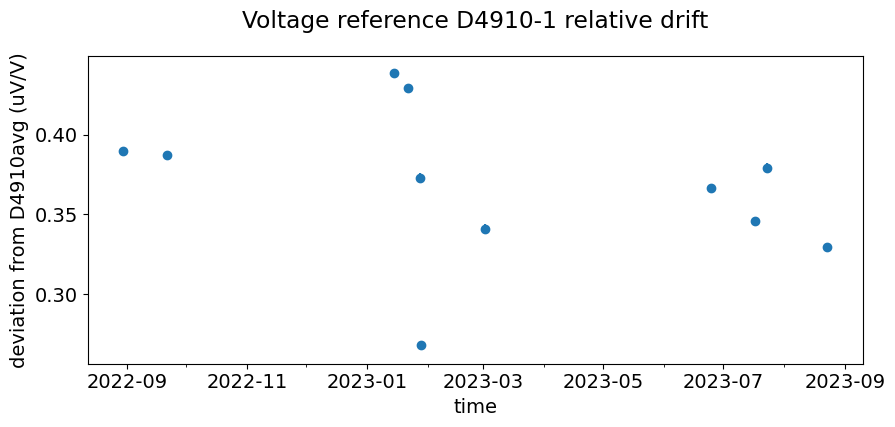

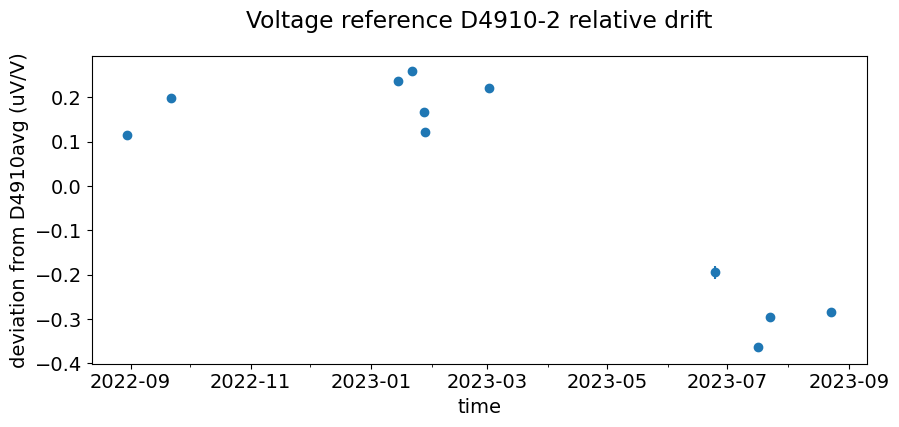

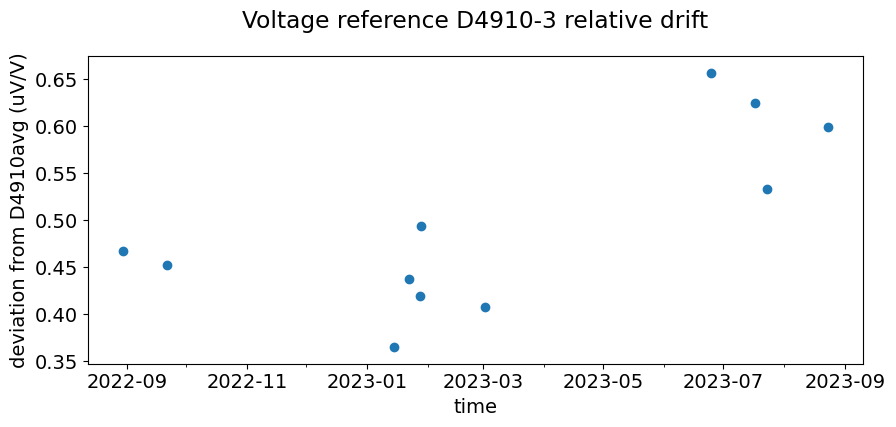

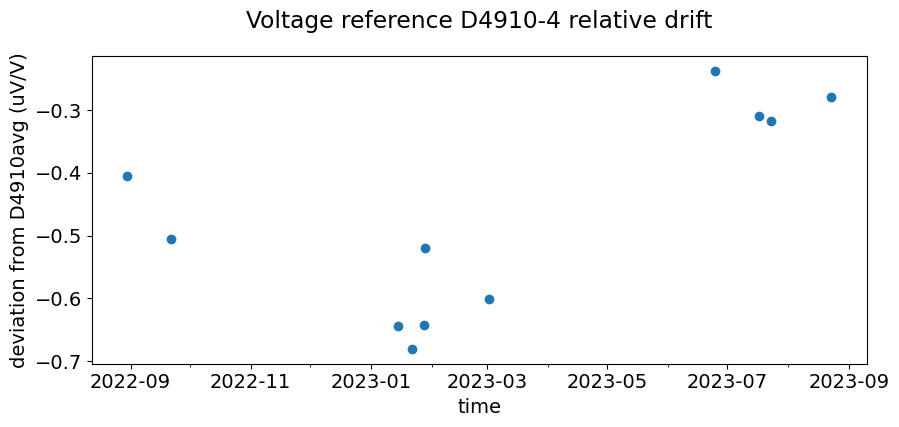

In [26]:
plt.rcParams["figure.figsize"] = (10,4)

# rel_results[[(ref, param) for ref in voltage_references for param in ('mean', 'sem', 'datetime')]]
rel_D4910avg_results = rel_D4910avg_results.dropna()
for ref in voltage_references:  
    plt.errorbar(rel_D4910avg_results[(ref, 'datetime')].dropna(), rel_D4910avg_results[(ref, 'mean')].dropna(), yerr=rel_D4910avg_results[(ref, 'sem')].dropna(), label=ref, fmt='o')
    plt.xlabel('time')
    plt.ylabel('deviation from D4910avg (uV/V)')
    plt.title(f'Voltage reference {ref} relative drift', pad=20)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    plt.show()

## D4910 cells relative to F7001bat vs D4910avg

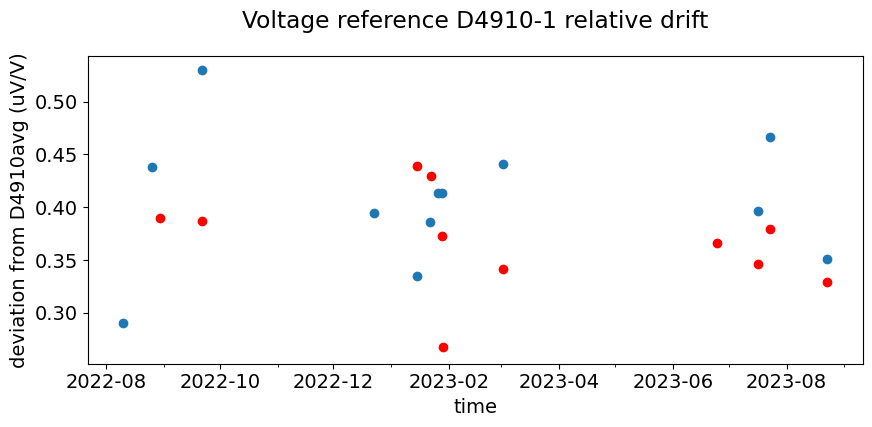

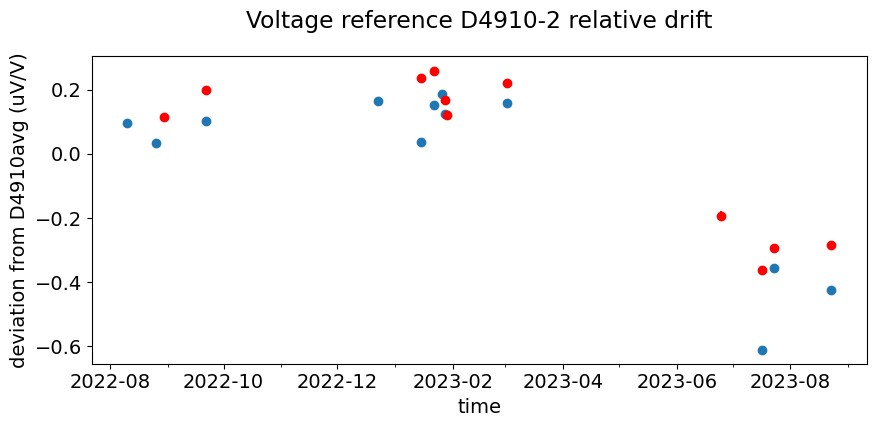

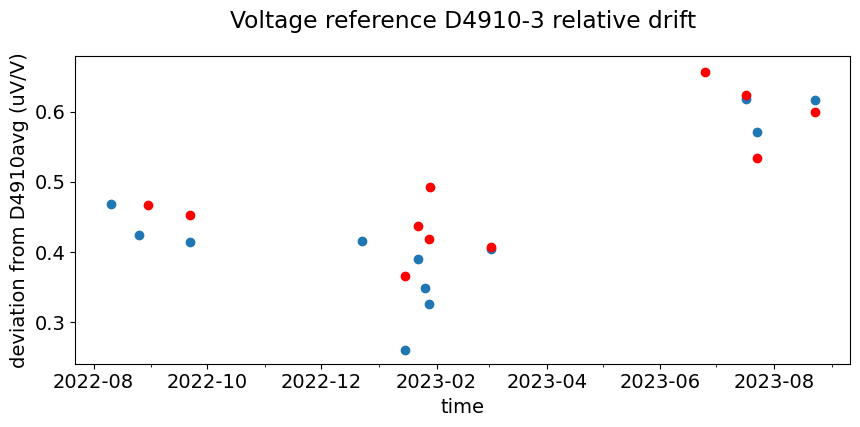

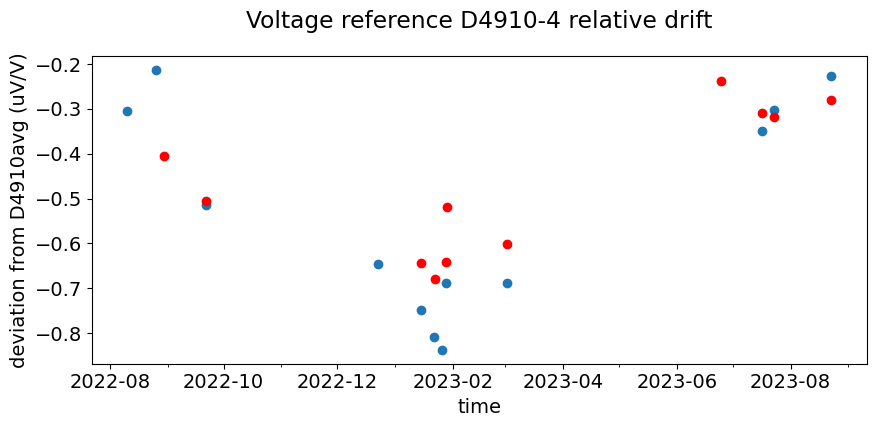

In [29]:
plt.rcParams["figure.figsize"] = (10,4)

# rel_results[[(ref, param) for ref in voltage_references for param in ('mean', 'sem', 'datetime')]]
rel_results = rel_results.dropna()
for ref in voltage_references:
    if not ref.startswith('D4910-'):
        continue
    dates = rel_results[(ref, 'datetime')]
    means = rel_results[(ref, 'mean')]
    D4910_date_index = pd.DatetimeIndex(rel_results[('D4910avg', 'datetime')])
    D4910_indices = D4910_date_index.get_indexer(dates, method='nearest', tolerance=pd.Timedelta('1 day'))
    D4910_values = rel_results[('D4910avg', 'mean')].iloc[D4910_indices]
    results_relative_to_D4910avg = means - D4910_values
    plt.scatter(rel_results[(ref, 'datetime')].dropna(), results_relative_to_D4910avg.dropna(), label=ref)
    plt.errorbar(rel_D4910avg_results[(ref, 'datetime')].dropna(), rel_D4910avg_results[(ref, 'mean')].dropna(), yerr=rel_D4910avg_results[(ref, 'sem')].dropna(), label=ref, fmt='o', color='red')
    plt.xlabel('time')
    plt.ylabel('deviation from D4910avg (uV/V)')
    plt.title(f'Voltage reference {ref} relative drift', pad=20)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    plt.show()


# Misc analyses

## Check groupings

### k182_relative_data

In [9]:
orig_max_rows = pd.get_option('display.max_rows')
# pd.set_option('display.max_rows', None)
duration_data = k182_rel_data_cut.reset_index().groupby(['group', 'dut_neg_lead', 'dut_pos_lead']).agg({'datetime': ['min', 'max', 'mean']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
# pd.set_option('display.max_rows', orig_max_rows)
all_duration_data = duration_data

datetime  \
                                                       min   
group dut_neg_lead dut_pos_lead                              
0     F732a3       short        2022-08-25 10:54:36.345585   
      F7001bat     F732a3       2022-08-25 11:10:49.192938   
      F732a3       F7001bat     2022-08-25 11:11:47.817884   
      F7001bat     F732a2       2022-08-25 11:15:00.538933   
      F732a2       F7001bat     2022-08-25 11:16:11.098328   
...                                                    ...   
16    F732a2       F7001bat     2023-08-22 21:45:11.496808   
      F732a3       F7001bat     2023-08-22 21:47:01.977872   
      F7001bat     F732a3       2023-08-22 21:48:20.017170   
                   F732a1       2023-08-22 21:51:30.474028   
      F732a1       F7001bat     2023-08-22 21:52:54.676099   

                                                            \
                                                       max   
group dut_neg_lead dut_pos_lead                              
0     F732a3       short        2022-08-25 11:06:46.667221   
      F7001bat     F732a3       2022-08-25 11:58:48.855236   
      F732a3       F7001bat     2022-08-25 11:50:50.202934   
      F7001bat     F732a2       2022-08-25 11:15:30.455669   
      F732a2       F7001bat     2022-08-25 12:13:37.153488   
...                                                    ...   
16    F732a2       F7001bat     2023-08-22 21:46:05.162649   
      F732a3       F7001bat     2023-08-22 21:47:47.234245   
      F7001bat     F732a3       2023-08-22 21:49:05.043415   
                   F732a1       2023-08-22 21:52:07.550030   
      F732a1       F7001bat     2023-08-22 21:53:36.868565   

                                                               \
                                                         mean   
group dut_neg_lead dut_pos_lead                                 
0     F732a3       short        2022-08-25 11:00:41.953482496   
      F7001bat     F732a3       2022-08-25 11:52:51.826954752   
      F732a3       F7001bat     2022-08-25 11:35:25.070860288   
      F7001bat     F732a2       2022-08-25 11:15:15.487952896   
      F732a2       F7001bat     2022-08-25 12:01:40.469089792   
...                                                       ...   
16    F732a2       F7001bat     2023-08-22 21:45:38.370508800   
      F732a3       F7001bat     2023-08-22 21:47:24.581259520   
      F7001bat     F732a3       2023-08-22 21:48:42.535990272   
                   F732a1       2023-08-22 21:51:48.975383552   
      F732a1       F7001bat     2023-08-22 21:53:15.698974464   

                                              duration  
                                                        
group dut_neg_lead dut_pos_lead                         
0     F732a3       short        0 days 00:12:10.321636  
      F7001bat     F732a3       0 days 00:47:59.662298  
      F732a3       F7001bat     0 days 00:39:02.385050  
      F7001bat     F732a2       0 days 00:00:29.916736  
      F732a2       F7001bat     0 days 00:57:26.055160  
...                                                ...  
16    F732a2       F7001bat     0 days 00:00:53.665841  
      F732a3       F7001bat     0 days 00:00:45.256373  
      F7001bat     F732a3       0 days 00:00:45.026245  
                   F732a1       0 days 00:00:37.076002  
      F732a1       F7001bat     0 days 00:00:42.192466  

[337 rows x 4 columns]

### ag3458a_rel_data

In [10]:
orig_max_rows = pd.get_option('display.max_rows')
# pd.set_option('display.max_rows', None)
duration_data = ag3458a_rel_data.reset_index().groupby(['group', 'dut_neg_lead', 'dut_pos_lead']).agg({'datetime': ['min', 'max', 'mean']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
# pd.set_option('display.max_rows', orig_max_rows)
all_duration_data = pd.concat([all_duration_data, duration_data])
all_duration_data

datetime  \
                                                       min   
group dut_neg_lead dut_pos_lead                              
0     D4910avg     F7001bat     2022-08-10 01:28:59.711916   
      F7001bat     D4910avg     2022-08-10 01:33:52.224816   
                   D4910-1      2022-08-10 01:44:02.558776   
      D4910-1      F7001bat     2022-08-10 01:51:36.222159   
      D4910-2      F7001bat     2022-08-10 01:59:20.068137   
      F7001bat     D4910-2      2022-08-10 02:06:14.304998   
                   D4910-3      2022-08-10 02:09:04.730457   
      D4910-3      F7001bat     2022-08-10 02:14:15.811525   
      D4910-4      F7001bat     2022-08-10 02:17:17.205464   
      F7001bat     D4910-4      2022-08-10 02:20:17.535474   
      F732a1       F7001bat     2022-08-10 02:38:57.622169   
      F7001bat     F732a1       2022-08-10 02:43:22.142429   
                   F732a3       2022-08-10 02:48:29.379110   
      F732a3       F7001bat     2022-08-10 02:52:15.031834   
      F732a2       F7001bat     2022-08-10 02:56:37.414828   
      F7001bat     F732a2       2022-08-10 03:03:27.922068   

                                                            \
                                                       max   
group dut_neg_lead dut_pos_lead                              
0     D4910avg     F7001bat     2022-08-10 03:18:04.621361   
      F7001bat     D4910avg     2022-08-10 03:12:03.621322   
                   D4910-1      2022-08-10 01:50:18.250952   
      D4910-1      F7001bat     2022-08-10 01:54:08.639030   
      D4910-2      F7001bat     2022-08-10 02:01:01.371553   
      F7001bat     D4910-2      2022-08-10 02:08:26.091012   
                   D4910-3      2022-08-10 02:11:31.643546   
      D4910-3      F7001bat     2022-08-10 02:16:12.291561   
      D4910-4      F7001bat     2022-08-10 02:19:03.577417   
      F7001bat     D4910-4      2022-08-10 02:22:31.001556   
      F732a1       F7001bat     2022-08-10 02:40:33.865399   
      F7001bat     F732a1       2022-08-10 02:45:23.708859   
                   F732a3       2022-08-10 02:50:51.225480   
      F732a3       F7001bat     2022-08-10 02:54:42.003983   
      F732a2       F7001bat     2022-08-10 02:59:14.445236   
      F7001bat     F732a2       2022-08-10 03:06:25.205327   

                                                               \
                                                         mean   
group dut_neg_lead dut_pos_lead                                 
0     D4910avg     F7001bat     2022-08-10 02:32:04.596553728   
      F7001bat     D4910avg     2022-08-10 02:11:42.607617792   
                   D4910-1      2022-08-10 01:47:10.186413312   
      D4910-1      F7001bat     2022-08-10 01:52:52.418054144   
      D4910-2      F7001bat     2022-08-10 02:00:10.719646464   
      F7001bat     D4910-2      2022-08-10 02:07:20.208248320   
                   D4910-3      2022-08-10 02:10:18.190561792   
      D4910-3      F7001bat     2022-08-10 02:15:14.054734080   
      D4910-4      F7001bat     2022-08-10 02:18:10.389515264   
      F7001bat     D4910-4      2022-08-10 02:21:23.762162944   
      F732a1       F7001bat     2022-08-10 02:39:45.735740672   
      F7001bat     F732a1       2022-08-10 02:44:22.916991232   
                   F732a3       2022-08-10 02:49:40.302406656   
      F732a3       F7001bat     2022-08-10 02:53:28.516777216   
      F732a2       F7001bat     2022-08-10 02:57:55.923575296   
      F7001bat     F732a2       2022-08-10 03:04:56.557348352   

                                              duration  
                                                        
group dut_neg_lead dut_pos_lead                         
0     D4910avg     F7001bat     0 days 01:49:04.909445  
      F7001bat     D4910avg     0 days 01:38:11.396506  
                   D4910-1      0 days 00:06:15.692176  
      D4910-1      F7001bat     0 days 00:02:32.416871  
      D4910-2      F7001bat     0 days 00:01:41.303416  


datetime  \
                                                       min   
group dut_neg_lead dut_pos_lead                              
0     D4910-1      F7001bat     2022-08-25 12:26:34.963214   
      D4910-2      F7001bat     2022-08-25 12:27:26.435180   
      D4910-3      F7001bat     2022-08-25 12:31:39.562114   
      D4910-4      F7001bat     2022-08-25 12:33:50.013982   
      D4910avg     F7001bat     2022-08-25 12:17:05.303089   
...                                                    ...   
      F7001bat     F732a2       2022-08-10 03:03:27.922068   
                   F732a3       2022-08-10 02:48:29.379110   
      F732a1       F7001bat     2022-08-10 02:38:57.622169   
      F732a2       F7001bat     2022-08-10 02:56:37.414828   
      F732a3       F7001bat     2022-08-10 02:52:15.031834   

                                                            \
                                                       max   
group dut_neg_lead dut_pos_lead                              
0     D4910-1      F7001bat     2022-08-25 12:26:58.923490   
      D4910-2      F7001bat     2022-08-25 12:28:30.836231   
      D4910-3      F7001bat     2022-08-25 12:32:17.286253   
      D4910-4      F7001bat     2022-08-25 12:35:40.598801   
      D4910avg     F7001bat     2022-08-25 12:48:17.064275   
...                                                    ...   
      F7001bat     F732a2       2022-08-10 03:06:25.205327   
                   F732a3       2022-08-10 02:50:51.225480   
      F732a1       F7001bat     2022-08-10 02:40:33.865399   
      F732a2       F7001bat     2022-08-10 02:59:14.445236   
      F732a3       F7001bat     2022-08-10 02:54:42.003983   

                                                               \
                                                         mean   
group dut_neg_lead dut_pos_lead                                 
0     D4910-1      F7001bat     2022-08-25 12:26:47.326725376   
      D4910-2      F7001bat     2022-08-25 12:27:59.010249984   
      D4910-3      F7001bat     2022-08-25 12:31:57.739055104   
      D4910-4      F7001bat     2022-08-25 12:34:26.750688000   
      D4910avg     F7001bat     2022-08-25 12:39:47.189152000   
...                                                       ...   
      F7001bat     F732a2       2022-08-10 03:04:56.557348352   
                   F732a3       2022-08-10 02:49:40.302406656   
      F732a1       F7001bat     2022-08-10 02:39:45.735740672   
      F732a2       F7001bat     2022-08-10 02:57:55.923575296   
      F732a3       F7001bat     2022-08-10 02:53:28.516777216   

                                              duration  
                                                        
group dut_neg_lead dut_pos_lead                         
0     D4910-1      F7001bat     0 days 00:00:23.960276  
      D4910-2      F7001bat     0 days 00:01:04.401051  
      D4910-3      F7001bat     0 days 00:00:37.724139  
      D4910-4      F7001bat     0 days 00:01:50.584819  
      D4910avg     F7001bat     0 days 00:31:11.761186  
...                                                ...  
      F7001bat     F732a2       0 days 00:02:57.283259  
                   F732a3       0 days 00:02:21.846370  
      F732a1       F7001bat     0 days 00:01:36.243230  
      F732a2       F7001bat     0 days 00:02:37.030408  
      F732a3       F7001bat     0 days 00:02:26.972149  

[353 rows x 4 columns]

### ag3458a_1_abs_data

In [11]:
orig_max_rows = pd.get_option('display.max_rows')
# pd.set_option('display.max_rows', None)
data_with_neg_lead = ag3458a_1_abs_data_cut.reset_index().rename(columns={'dut': 'dut_pos_lead'})
data_with_neg_lead['dut_neg_lead'] = 'ag3458a_1'
duration_data = data_with_neg_lead.groupby(['group', 'dut_neg_lead', 'dut_pos_lead']).agg({'datetime': ['min', 'max', 'mean']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
# pd.set_option('display.max_rows', orig_max_rows)
np.unique(ag3458a_1_abs_data_cut[ag3458a_1_abs_data_cut.group == 2].index.date)
all_duration_data = pd.concat([all_duration_data, duration_data])

datetime  \
                                                         min   
group dut_neg_lead dut_pos_lead                                
0     ag3458a_1    D4910avg       2021-09-13 01:13:07.779134   
1     ag3458a_1    D4910avg       2021-11-15 12:02:46.347705   
2     ag3458a_1    D4910avg       2021-11-17 21:34:21.608514   
                   D4910-1        2021-11-17 21:43:40.639165   
                   D4910-2        2021-11-17 21:52:13.707073   
...                                                      ...   
12    ag3458a_1    LT1021CMH-10-2 2023-07-17 01:06:44.000818   
                   LT1021CMH-10-3 2023-07-17 01:11:09.106796   
                   LT1021CMH-10-4 2023-07-17 01:18:12.980195   
                   LT1021CMH-10-5 2023-07-17 01:23:33.599174   
13    ag3458a_1    F7001bat       2023-08-22 23:13:04.293585   

                                                              \
                                                         max   
group dut_neg_lead dut_pos_lead                                
0     ag3458a_1    D4910avg       2021-09-13 01:19:14.231825   
1     ag3458a_1    D4910avg       2021-11-15 13:59:46.780667   
2     ag3458a_1    D4910avg       2021-11-17 23:41:11.154469   
                   D4910-1        2021-11-17 21:51:22.598264   
                   D4910-2        2021-11-17 22:00:23.203927   
...                                                      ...   
12    ag3458a_1    LT1021CMH-10-2 2023-07-17 01:09:56.845231   
                   LT1021CMH-10-3 2023-07-17 01:15:11.084452   
                   LT1021CMH-10-4 2023-07-17 01:22:02.705911   
                   LT1021CMH-10-5 2023-07-17 01:29:18.216491   
13    ag3458a_1    F7001bat       2023-08-22 23:23:24.480157   

                                                                 \
                                                           mean   
group dut_neg_lead dut_pos_lead                                   
0     ag3458a_1    D4910avg       2021-09-13 01:16:11.109984256   
1     ag3458a_1    D4910avg       2021-11-15 12:21:11.694705664   
2     ag3458a_1    D4910avg       2021-11-17 22:37:49.348003584   
                   D4910-1        2021-11-17 21:47:29.652073984   
                   D4910-2        2021-11-17 21:56:24.790477312   
...                                                         ...   
12    ag3458a_1    LT1021CMH-10-2 2023-07-17 01:08:20.418955264   
                   LT1021CMH-10-3 2023-07-17 01:13:10.100621568   
                   LT1021CMH-10-4 2023-07-17 01:20:07.833321984   
                   LT1021CMH-10-5 2023-07-17 01:26:25.873496576   
13    ag3458a_1    F7001bat       2023-08-22 23:18:15.178355968   

                                                duration  
                                                          
group dut_neg_lead dut_pos_lead                           
0     ag3458a_1    D4910avg       0 days 00:06:06.452691  
1     ag3458a_1    D4910avg       0 days 01:57:00.432962  
2     ag3458a_1    D4910avg       0 days 02:06:49.545955  
                   D4910-1        0 days 00:07:41.959099  
                   D4910-2        0 days 00:08:09.496854  
...                                                  ...  
12    ag3458a_1    LT1021CMH-10-2 0 days 00:03:12.844413  
                   LT1021CMH-10-3 0 days 00:04:01.977656  
                   LT1021CMH-10-4 0 days 00:03:49.725716  
                   LT1021CMH-10-5 0 days 00:05:44.617317  
13    ag3458a_1    F7001bat       0 days 00:10:20.186572  

[129 rows x 4 columns]

### ag3458a_2_abs_data

In [12]:
orig_max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', None)
data_with_neg_lead = ag3458a_2_abs_data.reset_index().rename(columns={'dut': 'dut_pos_lead'})
data_with_neg_lead['dut_neg_lead'] = 'ag3458a_2'
duration_data = data_with_neg_lead.groupby(['group', 'dut_neg_lead', 'dut_pos_lead']).agg({'datetime': ['min', 'max', 'mean']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
pd.set_option('display.max_rows', orig_max_rows)
all_duration_data = pd.concat([all_duration_data, duration_data])

datetime  \
                                                             min   
group dut_neg_lead dut_pos_lead                                    
0     ag3458a_2    F7001-SMPS-Au799ln 2021-09-10 10:01:16.672755   
                   F732a2             2021-09-10 10:03:24.330000   
                   D4910avg           2021-09-10 10:04:52.182880   
1     ag3458a_2    D4910avg           2021-09-12 22:17:33.380947   
                   F7001              2021-09-12 22:43:20.135285   
                   F7001-SMPS-Au799ln 2021-09-12 22:51:43.314149   
                   F732a2             2021-09-12 23:01:35.691370   
                   F732a1             2021-09-12 23:06:29.808999   
                   F732a3             2021-09-12 23:12:47.715171   
2     ag3458a_2    F7001bat           2022-12-25 02:39:14.842788   
3     ag3458a_2    F7001bat           2023-07-17 01:54:35.303091   
4     ag3458a_2    F7001bat           2023-08-22 23:01:48.208576   

                                                                  \
                                                             max   
group dut_neg_lead dut_pos_lead                                    
0     ag3458a_2    F7001-SMPS-Au799ln 2021-09-10 10:02:37.092581   
                   F732a2             2021-09-10 10:03:54.487813   
                   D4910avg           2021-09-10 10:07:53.086176   
1     ag3458a_2    D4910avg           2021-09-13 01:39:51.978332   
                   F7001              2021-09-12 23:35:48.901632   
                   F7001-SMPS-Au799ln 2021-09-12 22:56:34.825195   
                   F732a2             2021-09-12 23:31:53.970455   
                   F732a1             2021-09-12 23:27:52.888710   
                   F732a3             2021-09-12 23:23:01.281511   
2     ag3458a_2    F7001bat           2022-12-25 03:00:32.842690   
3     ag3458a_2    F7001bat           2023-07-17 02:11:27.059450   
4     ag3458a_2    F7001bat           2023-08-22 23:09:44.062728   

                                                                     \
                                                               mean   
group dut_neg_lead dut_pos_lead                                       
0     ag3458a_2    F7001-SMPS-Au799ln 2021-09-10 10:01:56.882341376   
                   F732a2             2021-09-10 10:03:39.407108608   
                   D4910avg           2021-09-10 10:06:22.641925120   
1     ag3458a_2    D4910avg           2021-09-13 00:37:03.027739392   
                   F7001              2021-09-12 23:03:46.068179200   
                   F7001-SMPS-Au799ln 2021-09-12 22:54:09.071528704   
                   F732a2             2021-09-12 23:16:44.824498176   
                   F732a1             2021-09-12 23:15:57.327261952   
                   F732a3             2021-09-12 23:17:40.807410176   
2     ag3458a_2    F7001bat           2022-12-25 02:50:37.810305280   
3     ag3458a_2    F7001bat           2023-07-17 02:02:48.841576960   
4     ag3458a_2    F7001bat           2023-08-22 23:05:49.307595008   

                                                    duration  
                                                              
group dut_neg_lead dut_pos_lead                               
0     ag3458a_2    F7001-SMPS-Au799ln 0 days 00:01:20.419826  
                   F732a2             0 days 00:00:30.157813  
                   D4910avg           0 days 00:03:00.903296  
1     ag3458a_2    D4910avg           0 days 03:22:18.597385  
                   F7001              0 days 00:52:28.766347  
                   F7001-SMPS-Au799ln 0 days 00:04:51.511046  
                   F732a2             0 days 00:30:18.279085  
                   F732a1             0 days 00:21:23.079711  
                   F732a3             0 days 00:10:13.566340  
2     ag3458a_2    F7001bat           0 days 00:21:17.999902  
3     ag3458a_2    F7001bat           0 days 00:16:51.756359  
4     ag3458a_2    F7001bat           0 days 00:07:55.854152

### All duration data combined

In [13]:
orig_max_rows = pd.get_option('display.max_rows')
# pd.set_option('display.max_rows', None)
display(all_duration_data.sort_values(('datetime', 'min')))
# pd.set_option('display.max_rows', orig_max_rows)

datetime  \
                                                             min   
group dut_neg_lead dut_pos_lead                                    
0     ag3458a_2    F7001-SMPS-Au799ln 2021-09-10 10:01:16.672755   
                   F732a2             2021-09-10 10:03:24.330000   
                   D4910avg           2021-09-10 10:04:52.182880   
1     ag3458a_2    D4910avg           2021-09-12 22:17:33.380947   
                   F7001              2021-09-12 22:43:20.135285   
...                                                          ...   
16    F7001bat     F732a3             2023-08-22 21:48:20.017170   
                   F732a1             2023-08-22 21:51:30.474028   
      F732a1       F7001bat           2023-08-22 21:52:54.676099   
4     ag3458a_2    F7001bat           2023-08-22 23:01:48.208576   
13    ag3458a_1    F7001bat           2023-08-22 23:13:04.293585   

                                                                  \
                                                             max   
group dut_neg_lead dut_pos_lead                                    
0     ag3458a_2    F7001-SMPS-Au799ln 2021-09-10 10:02:37.092581   
                   F732a2             2021-09-10 10:03:54.487813   
                   D4910avg           2021-09-10 10:07:53.086176   
1     ag3458a_2    D4910avg           2021-09-13 01:39:51.978332   
                   F7001              2021-09-12 23:35:48.901632   
...                                                          ...   
16    F7001bat     F732a3             2023-08-22 21:49:05.043415   
                   F732a1             2023-08-22 21:52:07.550030   
      F732a1       F7001bat           2023-08-22 21:53:36.868565   
4     ag3458a_2    F7001bat           2023-08-22 23:09:44.062728   
13    ag3458a_1    F7001bat           2023-08-22 23:23:24.480157   

                                                                     \
                                                               mean   
group dut_neg_lead dut_pos_lead                                       
0     ag3458a_2    F7001-SMPS-Au799ln 2021-09-10 10:01:56.882341376   
                   F732a2             2021-09-10 10:03:39.407108608   
                   D4910avg           2021-09-10 10:06:22.641925120   
1     ag3458a_2    D4910avg           2021-09-13 00:37:03.027739392   
                   F7001              2021-09-12 23:03:46.068179200   
...                                                             ...   
16    F7001bat     F732a3             2023-08-22 21:48:42.535990272   
                   F732a1             2023-08-22 21:51:48.975383552   
      F732a1       F7001bat           2023-08-22 21:53:15.698974464   
4     ag3458a_2    F7001bat           2023-08-22 23:05:49.307595008   
13    ag3458a_1    F7001bat           2023-08-22 23:18:15.178355968   

                                                    duration  
                                                              
group dut_neg_lead dut_pos_lead                               
0     ag3458a_2    F7001-SMPS-Au799ln 0 days 00:01:20.419826  
                   F732a2             0 days 00:00:30.157813  
                   D4910avg           0 days 00:03:00.903296  
1     ag3458a_2    D4910avg           0 days 03:22:18.597385  
                   F7001              0 days 00:52:28.766347  
...                                                      ...  
16    F7001bat     F732a3             0 days 00:00:45.026245  
                   F732a1             0 days 00:00:37.076002  
      F732a1       F7001bat           0 days 00:00:42.192466  
4     ag3458a_2    F7001bat           0 days 00:07:55.854152  
13    ag3458a_1    F7001bat           0 days 00:10:20.186572  

[494 rows x 4 columns]

In [14]:
groups_by_48h = all_duration_data.reset_index().groupby([pd.Grouper(key=('datetime', 'mean'), freq="2D"), 'dut_neg_lead', 'dut_pos_lead']).agg({('datetime', 'min'): 'min', ('datetime', 'max'): 'max', ('duration',''): 'sum'}).dropna()
groups_by_48h_2 = all_duration_data.reset_index().groupby([pd.Grouper(key=('datetime', 'mean'), freq="2D", offset=pd.Timedelta("1 days")), 'dut_neg_lead', 'dut_pos_lead']).agg({('datetime', 'min'): 'min', ('datetime', 'max'): 'max', ('duration',''): 'sum'}).dropna()
display_full_df(groups_by_48h)
display_full_df(groups_by_48h_2)

datetime  \
                                                                        min   
(datetime, mean) dut_neg_lead dut_pos_lead                                    
2021-09-10       ag3458a_2    D4910avg           2021-09-10 10:04:52.182880   
                              F7001-SMPS-Au799ln 2021-09-10 10:01:16.672755   
                              F732a2             2021-09-10 10:03:24.330000   
2021-09-12       ag3458a_1    D4910avg           2021-09-13 01:13:07.779134   
                 ag3458a_2    D4910avg           2021-09-12 22:17:33.380947   
                              F7001              2021-09-12 22:43:20.135285   
                              F7001-SMPS-Au799ln 2021-09-12 22:51:43.314149   
                              F732a1             2021-09-12 23:06:29.808999   
                              F732a2             2021-09-12 23:01:35.691370   
                              F732a3             2021-09-12 23:12:47.715171   
2021-11-15       ag3458a_1    D4910avg           2021-11-15 12:02:46.347705   
2021-11-17       ag3458a_1    D4910-1            2021-11-17 21:43:40.639165   
                              D4910-2            2021-11-17 21:52:13.707073   
                              D4910-3            2021-11-17 22:01:03.708580   
                              D4910-4            2021-11-17 22:14:23.978300   
                              D4910avg           2021-11-17 21:34:21.608514   
                              F7001              2021-11-17 22:48:06.302977   
                              F7001bat           2021-11-17 23:42:01.955847   
                              F732a1             2021-11-17 22:56:50.634225   
                              F732a2             2021-11-17 23:16:40.332361   
                              F732a3             2021-11-17 23:06:15.396853   
2022-04-18       ag3458a_1    D4910-1            2022-04-19 01:09:49.794657   
                              D4910-2            2022-04-19 01:23:23.510141   
                              D4910-3            2022-04-19 01:35:26.978687   
                              D4910-4            2022-04-19 01:44:21.125066   
                              D4910avg           2022-04-18 21:35:24.253048   
                              F7001              2022-04-18 22:38:34.637707   
                              F732a1             2022-04-18 21:54:32.069056   
                              F732a2             2022-04-18 22:14:01.739416   
                              F732a3             2022-04-19 00:22:14.733987   
2022-08-08       ag3458a_1    F7001              2022-08-09 22:49:59.001239   
                              F7001bat           2022-08-09 22:57:56.888908   
                              F732a1             2022-08-09 23:54:17.381498   
                              F732a2             2022-08-09 23:32:39.433347   
                              F732a3             2022-08-09 23:42:32.575772   
2022-08-10       D4910-1      F7001bat           2022-08-10 01:51:36.222159   
                 D4910-2      F7001bat           2022-08-10 01:59:20.068137   
                 D4910-3      F7001bat           2022-08-10 02:14:15.811525   
                 D4910-4      F7001bat           2022-08-10 02:17:17.205464   
                 D4910avg     F7001bat           2022-08-10 01:28:59.711916   
                 F7001bat     D4910-1            2022-08-10 01:44:02.558776   
                              D4910-2            2022-08-10 02:06:14.304998   
                              D4910-3            2022-08-10 02:09:04.730457   
                              D4910-4            2022-08-10 02:20:17.535474   
                              D4910avg           2022-08-10 01:33:52.224816   
                              F732a1             2022-08-10 02:43:22.142429   
                              F732a2             2022-08-10 03:03:27.922068   
                              F732a3             2022-08-10 02:48:29.379110   
                 F732a1       F7001bat

datetime  \
                                                                        min   
(datetime, mean) dut_neg_lead dut_pos_lead                                    
2021-09-09       ag3458a_2    D4910avg           2021-09-10 10:04:52.182880   
                              F7001-SMPS-Au799ln 2021-09-10 10:01:16.672755   
                              F732a2             2021-09-10 10:03:24.330000   
2021-09-11       ag3458a_2    F7001              2021-09-12 22:43:20.135285   
                              F7001-SMPS-Au799ln 2021-09-12 22:51:43.314149   
                              F732a1             2021-09-12 23:06:29.808999   
                              F732a2             2021-09-12 23:01:35.691370   
                              F732a3             2021-09-12 23:12:47.715171   
2021-09-13       ag3458a_1    D4910avg           2021-09-13 01:13:07.779134   
                 ag3458a_2    D4910avg           2021-09-12 22:17:33.380947   
2021-11-14       ag3458a_1    D4910avg           2021-11-15 12:02:46.347705   
2021-11-16       ag3458a_1    D4910-1            2021-11-17 21:43:40.639165   
                              D4910-2            2021-11-17 21:52:13.707073   
                              D4910-3            2021-11-17 22:01:03.708580   
                              D4910-4            2021-11-17 22:14:23.978300   
                              D4910avg           2021-11-17 21:34:21.608514   
                              F7001              2021-11-17 22:48:06.302977   
                              F7001bat           2021-11-17 23:42:01.955847   
                              F732a1             2021-11-17 22:56:50.634225   
                              F732a2             2021-11-17 23:16:40.332361   
                              F732a3             2021-11-17 23:06:15.396853   
2022-04-17       ag3458a_1    F7001              2022-04-18 22:38:34.637707   
                              F732a1             2022-04-18 21:54:32.069056   
                              F732a2             2022-04-18 22:14:01.739416   
2022-04-19       ag3458a_1    D4910-1            2022-04-19 01:09:49.794657   
                              D4910-2            2022-04-19 01:23:23.510141   
                              D4910-3            2022-04-19 01:35:26.978687   
                              D4910-4            2022-04-19 01:44:21.125066   
                              D4910avg           2022-04-18 21:35:24.253048   
                              F732a3             2022-04-19 00:22:14.733987   
2022-08-09       D4910-1      F7001bat           2022-08-10 01:51:36.222159   
                 D4910-2      F7001bat           2022-08-10 01:59:20.068137   
                 D4910-3      F7001bat           2022-08-10 02:14:15.811525   
                 D4910-4      F7001bat           2022-08-10 02:17:17.205464   
                 D4910avg     F7001bat           2022-08-10 01:28:59.711916   
                 F7001bat     D4910-1            2022-08-10 01:44:02.558776   
                              D4910-2            2022-08-10 02:06:14.304998   
                              D4910-3            2022-08-10 02:09:04.730457   
                              D4910-4            2022-08-10 02:20:17.535474   
                              D4910avg           2022-08-10 01:33:52.224816   
                              F732a1             2022-08-10 02:43:22.142429   
                              F732a2             2022-08-10 03:03:27.922068   
                              F732a3             2022-08-10 02:48:29.379110   
                 F732a1       F7001bat           2022-08-10 02:38:57.622169   
                 F732a2       F7001bat           2022-08-10 02:56:37.414828   
                 F732a3       F7001bat           2022-08-10 02:52:15.031834   
                 ag3458a_1    D4910-1            2022-08-10 00:08:25.421378   
                              D4910-2            2022-08-10 00:23:37.371235   
                              D4910-3 

In [15]:
all_groups = pd.concat([groups_by_48h, groups_by_48h_2])
all_group_sets = all_groups.reset_index()[[('dut_neg_lead',''),('dut_pos_lead', ''), ('datetime', 'mean'), ('datetime', 'min'), ('datetime', 'max')]]
all_group_sets.columns = ['dut_neg_lead', 'dut_pos_lead', 'datetime', 'datetime_min', 'datetime_max']
all_group_sets_dates = all_group_sets.groupby('datetime').agg({'datetime_min': min, 'datetime_max': max})
all_group_sets_duts = all_group_sets.groupby('datetime').apply(lambda x: set(x.reset_index()[['dut_neg_lead', 'dut_pos_lead']].apply(lambda y: (y.dut_neg_lead, y.dut_pos_lead), axis=1).to_list()))
all_group_sets_grouped_by_date = all_group_sets_dates.join(all_group_sets_duts.rename('duts'), how='inner').reset_index()
all_group_sets_with_prev_and_next = pd.concat([all_group_sets_grouped_by_date, all_group_sets_grouped_by_date.shift(-1), all_group_sets_grouped_by_date.shift(1)], axis=1, keys=['current', 'next', 'prev'])
all_group_sets_with_prev_and_next
prev_group_within_1_day = (all_group_sets_with_prev_and_next[('current', 'datetime')] - all_group_sets_with_prev_and_next[('prev', 'datetime')] < pd.Timedelta('2 days'))
next_group_within_1_day = (all_group_sets_with_prev_and_next[('next', 'datetime')] - all_group_sets_with_prev_and_next[('current', 'datetime')] < pd.Timedelta('2 days'))
all_group_sets_with_prev_and_next.loc[~prev_group_within_1_day, ('prev', 'datetime')] = None
all_group_sets_with_prev_and_next.loc[~prev_group_within_1_day, ('prev', 'duts')] = np.nan
all_group_sets_with_prev_and_next.loc[~next_group_within_1_day, ('next', 'datetime')] = None
all_group_sets_with_prev_and_next.loc[~next_group_within_1_day, ('next', 'duts')] = np.nan
all_group_sets_with_prev_and_next['in_next'] = all_group_sets_with_prev_and_next.apply(lambda x: x[('current', 'duts')].issubset(x[('next', 'duts')]) if not pd.isna(x[('next', 'duts')]) else False, axis=1)
all_group_sets_with_prev_and_next['in_prev'] = all_group_sets_with_prev_and_next.apply(lambda x: x[('current', 'duts')].issubset(x[('prev', 'duts')]) if not pd.isna(x[('prev', 'duts')]) else False, axis=1)
all_group_sets_not_in_prev_or_current = all_group_sets_with_prev_and_next[~(all_group_sets_with_prev_and_next.in_prev | all_group_sets_with_prev_and_next.in_next)]
all_group_sets_not_in_prev_or_current

current                                                        \
     datetime               datetime_min               datetime_max   
3  2021-09-12 2021-09-12 22:17:33.380947 2021-09-13 01:39:51.978332   
10 2022-04-18 2022-04-18 21:35:24.253048 2022-04-19 02:11:31.926951   
13 2022-08-09 2022-08-09 22:49:59.001239 2022-08-10 03:18:04.621361   
16 2022-08-12 2022-08-12 20:23:16.362595 2022-08-13 01:56:29.962644   
23 2022-08-29 2022-08-29 08:24:27.698550 2022-08-30 02:30:26.882726   
26 2022-09-21 2022-09-21 14:38:34.325989 2022-09-22 20:19:30.200739   
27 2022-09-22 2022-09-21 23:06:34.223703 2022-09-24 00:34:58.759078   
28 2022-09-23 2022-09-22 21:39:14.015394 2022-09-25 03:04:08.015886   
29 2022-09-24 2022-09-24 00:36:27.794988 2022-09-25 12:00:46.317223   
30 2022-09-25 2022-09-25 03:04:47.840852 2022-09-26 22:20:45.326081   
41 2023-01-25 2023-01-25 22:18:41.265949 2023-01-26 08:34:59.796249   
43 2023-01-27 2023-01-27 23:23:57.145406 2023-01-28 16:08:23.099520   
50 2023-07-16 2023-07-16 19:47:15.798529 2023-07-17 02:27:26.072489   
53 2023-07-22 2023-07-22 22:10:56.961095 2023-07-23 00:49:48.040749   

                                                            next  \
                                                 duts   datetime   
3   {(ag3458a_2, F732a2), (ag3458a_2, F732a1), (ag... 2021-09-13   
10  {(ag3458a_1, D4910-3), (ag3458a_1, D4910-4), (... 2022-04-19   
13  {(D4910-4, F7001bat), (F7001bat, D4910avg), (F... 2022-08-10   
16  {(ag3458a_1, D4910-3), (ag3458a_1, D4910-4), (... 2022-08-13   
23  {(D4910avg, F732a2), (F7001bat, D4910avg), (F7... 2022-08-30   
26  {(F7001bat, D4910avg-bat), (D4910-4, F7001bat)... 2022-09-22   
27  {(ag3458a_1, D4910-3), (ag3458a_1, D4910-2), (... 2022-09-23   
28  {(ag3458a_1, D4910-3), (ag3458a_1, D4910-4), (... 2022-09-24   
29  {(ag3458a_1, D4910-4), (ag3458a_1, D4910-1), (... 2022-09-25   
30       {(ag3458a_1, F732a1), (ag3458a_1, D4910avg)} 2022-09-26   
41  {(D4910-4, F7001bat), (D4700+10V, F7001bat), (... 2023-01-26   
43  {(D4910-4, F7001bat), (F7001bat, D4910avg), (F... 2023-01-28   
50  {(ag3458a_1, LT1021CMH-10-4), (ag3458a_1, AD58... 2023-07-17   
53  {(D4910-4, F7001bat), (D4700+10V, F7001bat), (... 2023-07-23   

                                                          \
                 datetime_min               datetime_max   
3  2021-09-12 22:17:33.380947 2021-09-13 01:39:51.978332   
10 2022-04-18 21:35:24.253048 2022-04-19 02:11:31.926951   
13 2022-08-09 23:11:15.475188 2022-08-10 03:18:04.621361   
16 2022-08-12 23:33:56.978725 2022-08-13 01:41:02.817084   
23 2022-08-30 00:03:44.611842 2022-08-30 02:30:26.882726   
26 2022-09-21 23:06:34.223703 2022-09-24 00:34:58.759078   
27 2022-09-22 21:39:14.015394 2022-09-25 03:04:08.015886   
28 2022-09-24 00:36:27.794988 2022-09-25 12:00:46.317223   
29 2022-09-25 03:04:47.840852 2022-09-26 22:20:45.326081   
30 2022-09-25 12:02:19.934422 2022-09-26 22:20:45.326081   
41 2023-01-25 22:32:00.120786 2023-01-28 00:13:02.775860   
43 2023-01-28 00:00:01.754080 2023-01-28 16:08:23.099520   
50 2023-07-17 00:01:39.642040 2023-07-17 02:11:27.059450   
53 2023-07-22 23:21:03.392104 2023-07-23 00:49:48.040749   

                                                            prev  \
                                                 duts   datetime   
3      {(ag3458a_2, D4910avg), (ag3458a_1, D4910avg)} 2021-09-11   
10  {(ag3458a_1, D4910-3), (ag3458a_1, D4910-4), (... 2022-04-17   
13  {(D4910-4, F7001bat), (F7001bat, D4910avg), (F... 2022-08-08   
16  {(ag3458a_1, D4910-3), (ag3458a_1, D4910-4), (... 2022-08-11   
23  {(D4910-2, D4910avg), (D4910avg, D4910-3), (D4... 2022-08-28   
26  {(ag3458a_1, D4910-3), (ag3458a_1, D4910-2), (... 2022-09-20   
27  {(ag3458a_1, D4910-3), (ag3458a_1, D4910-4), (... 2022-09-21   
28  {(ag3458a_1, D4910-4), (ag3458a_1, D4910-1), (... 2022-09-22   
29       {(ag3458a_1, F732a1), (ag3458a_1, D4910avg)} 2022-09-23   
30                              {(ag3458a_1, F732a1)} 2022-09-24   
41 

In [16]:
"""
k199-x2-3458A-x1-F732A-MV106-log.csv.bz2
datetime,k199_1_f732a_mv106,k199_2_f732a_therm,ag3458a_1_f732a,temp_1,last_acal_1,last_acal_1_cal72
2020-04-26
2020-10-14
k199-x2-3458A-x1-k2000-x2-6031A-D4910-F732A-x3-log.csv.bz2
datetime,k199_1_d4910_avg_2,k199_2_d4910_avg_3,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_1_d4910_avg_f732a3,k2000_d4910_avg_4,k2000_20_d4910_avg_1,prema6031a_d4910_avg_f732a2
2021-04-18
2021-08-07
k199-x2-3458A-x2-F732A-MV106-log.csv.bz2
datetime,k199_1_f732a_mv106,k199_2_f732a_therm,ag3458a_1_f732a,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_2_f732a,temp_2,last_acal_2,last_acal_2_cal72
2018-12-08
2020-04-26
k199-x2-3458A-x2-k2000-x2-6031A-D4910-F732A-x2-F7001-log.csv.bz2
datetime,k199_1_d4910_avg_2,k199_2_d4910_avg_3,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_1_d4910_avg_f732a3,temp_2,last_acal_2,last_acal_2_cal72,ag3458a_2_d4910_avg_f7001,k2000_d4910_avg_4,k2000_20_d4910_avg_1,prema6031a_d4910_avg_f732a2
2021-08-07
2021-08-31
k199-x2-3458A-x2-k2000-x2-6031A-D4910-F732A-x3-F7001-log.csv.bz2
datetime,k199_1_d4910_avg_2,k199_2_d4910_avg_3,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_1_d4910_avg_f732a3,temp_2,last_acal_2,last_acal_2_cal72,ag3458a_2_d4910_avg_f7001,k2000_d4910_avg_f732a1,k2000_20_d4910_avg_1,prema6031a_d4910_avg_f732a2
2021-09-09
2021-09-10
k199-x2-3458A-x2-k2000-x2-D4910-F732A-MV106-log.csv.bz2
datetime,k199_1_f732a_mv106,k199_2_d4910_avg_4,ag3458a_1_d4910_avg_3,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_2_f732a_d4910_avg,temp_2,last_acal_2,last_acal_2_cal72,k2000_d4910_avg_1,k2000_20_d4910_avg_2
2020-10-14
2020-12-20
k199-x2-3458A-x2-k2000-x2-D4910-F732A-x2-log.csv.bz2
datetime,k199_1_d4910_avg_2,k199_2_d4910_avg_3,ag3458a_2_f732a2_d4910_avg,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_1_f732a1_d4910_avg,temp_2,last_acal_2,last_acal_2_cal72,k2000_d4910_avg_4,k2000_20_d4910_avg_1
2020-12-21
2021-04-03
k199-x2-3458A-x2-k2000-x-D4910-F732A-MV106-log.csv.bz2
datetime,k199_1_f732a_mv106,k199_2_d4910_avg_4,ag3458a_1_d4910_avg_3,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_2_f732a_d4910_avg,temp_2,last_acal_2,last_acal_2_cal72,k2000_d4910_avg_1,k2000_20_d4910_avg_2
2020-10-14
2020-10-14

3458A-x2-MV106.csv.bz2
datetime,ag3458a_1_mv106,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_2_mv106,temp_2,last_acal_2,last_acal_2_cal72
2018-06-30
2018-12-08
k199-x2-3456A-3458A-x2-F730A-6031A-8200-log.csv.bz2
datetime,ag3456a_ch1_2,k199_ch1_3,k199_ch1_4,ag3458a_1_ch1,temp_1,last_acal_1,last_acal_1_cal72,pr6031a_8200,ag3458a_2_ch1,temp_2,last_acal_2,last_acal_2_cal72
2018-02-27
2018-03-03
k199-x2-3458A-x2-F730A-6031A-8200-log.csv.bz2
datetime,k199_ch1_3,k199_ch1_4,ag3458a_1_ch1,temp_1,last_acal_1,last_acal_1_cal72,pr6031a_8200,ag3458a_2_ch1,temp_2,last_acal_2,last_acal_2_cal72
2018-03-03
2018-03-04
k199-x2-3458A-x2-F730A-PM2534-log.csv.bz2
datetime,pm2534_ch1_2,k199_ch1_3,k199_ch1_4,ag3458a_1_ch1,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_2_ch1,temp_2,last_acal_2,last_acal_2_cal72
2018-03-04
2018-03-31

"""

"""
k199-x2-3456A-3458A-x2-F730A-6031A-8200-log.csv.bz2
2018-02-27 - 2018-03-03: 2x 3458A
k199-x2-3458A-x2-F730A-6031A-8200-log.csv.bz2
2018-03-03 - 2018-03-04: 2x 3458A
k199-x2-3458A-x2-F730A-PM2534-log.csv.bz2
2018-03-04 - 2018-03-31: 2x 3458A
3458A-x2-MV106.csv.bz2
2018-06-30 - 2018-12-08: 2x 3458A
k199-x2-3458A-x2-F732A-MV106-log.csv.bz2
2018-12-08 - 2020-04-26: 2x 3458A, 1x F732A
k199-x2-3458A-x1-F732A-MV106-log.csv.bz2
2020-04-26 - 2020-10-14: 1x 3458A(_1), 1x F732A
k199-x2-3458A-x2-k2000-x-D4910-F732A-MV106-log.csv.bz2
k199-x2-3458A-x2-k2000-x2-D4910-F732A-MV106-log.csv.bz2
2020-10-14 - 2020-12-20: 2x 3458A, 1x F732A, D4910 avg, 1-4
k199-x2-3458A-x2-k2000-x2-D4910-F732A-x2-log.csv.bz2
2020-12-21 - 2021-04-03: 2x 3458A, 2x F732A, D4910 avg, 1-4
k199-x2-3458A-x1-k2000-x2-6031A-D4910-F732A-x3-log.csv.bz2
2021-04-18 - 2021-08-07: 1x 3458A(-1), 3x F732A, D4910 avg, 1-4
k199-x2-3458A-x2-k2000-x2-6031A-D4910-F732A-x2-F7001-log.csv.bz2
2021-08-07 - 2021-08-31: 2x 3458A, 2x F732A, D4910 avg, 1-4, F7001
k199-x2-3458A-x2-k2000-x2-6031A-D4910-F732A-x3-F7001-log.csv.bz2
2021-09-09 - 2021-09-10: 2x 3458A, 3x F732A, D4910 avg, 1-3, F7001
"""

'\nk199-x2-3456A-3458A-x2-F730A-6031A-8200-log.csv.bz2\n2018-02-27 - 2018-03-03: 2x 3458A\nk199-x2-3458A-x2-F730A-6031A-8200-log.csv.bz2\n2018-03-03 - 2018-03-04: 2x 3458A\nk199-x2-3458A-x2-F730A-PM2534-log.csv.bz2\n2018-03-04 - 2018-03-31: 2x 3458A\n3458A-x2-MV106.csv.bz2\n2018-06-30 - 2018-12-08: 2x 3458A\nk199-x2-3458A-x2-F732A-MV106-log.csv.bz2\n2018-12-08 - 2020-04-26: 2x 3458A, 1x F732A\nk199-x2-3458A-x1-F732A-MV106-log.csv.bz2\n2020-04-26 - 2020-10-14: 1x 3458A(_1), 1x F732A\nk199-x2-3458A-x2-k2000-x-D4910-F732A-MV106-log.csv.bz2\nk199-x2-3458A-x2-k2000-x2-D4910-F732A-MV106-log.csv.bz2\n2020-10-14 - 2020-12-20: 2x 3458A, 1x F732A, D4910 avg, 1-4\nk199-x2-3458A-x2-k2000-x2-D4910-F732A-x2-log.csv.bz2\n2020-12-21 - 2021-04-03: 2x 3458A, 2x F732A, D4910 avg, 1-4\nk199-x2-3458A-x1-k2000-x2-6031A-D4910-F732A-x3-log.csv.bz2\n2021-04-18 - 2021-08-07: 1x 3458A(-1), 3x F732A, D4910 avg, 1-4\nk199-x2-3458A-x2-k2000-x2-6031A-D4910-F732A-x2-F7001-log.csv.bz2\n2021-08-07 - 2021-08-31: 2x 3458

## Check number of samples taken

In [17]:
rel_counts = add_dut_neg_and_pos_group(relative_data_k182).groupby('group')['dut_neg_lead'].count()

<Axes: ylabel='Frequency'>

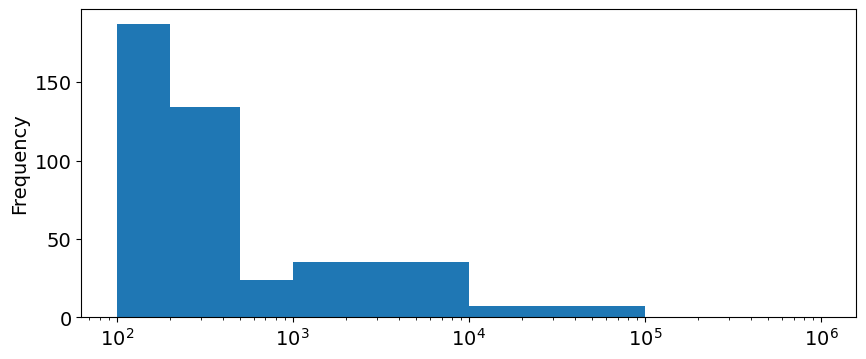

In [18]:
rel_counts.plot(kind="hist", logx=True, bins=[100,200, 500, 1e3,1e4,1e5,1e6])

In [19]:
relative_data_k182.groupby(by=['dut_pos_lead', 'dut_neg_lead']).count()

k182_dcv  temperature  pressure  humidity
dut_pos_lead dut_neg_lead                                           
D4190-3      D4910avg           191          191       191       191
D4190-4      D4910avg           201          201       201       201
D4700+10V    F7001bat           639          639       639       639
D4700-10V    F7001bat           817          817       817       817
D4910-1      D4910avg         11876        11876     11876     11876
             F7001bat          3610         3610      3610      3610
D4910-2      D4910avg          8532         8532      8532      8532
             F7001bat          2315         2315      2315      2315
D4910-3      D4910avg          3763         3763      3763      3763
             F7001bat          2159         2159      2159      2159
D4910-4      D4910avg          3968         3968      3968      3968
             F7001bat          2965         2965      2965      2965
D4910avg     D4190-2            230          230       230       230
             D4190-3            209          209       209       209
             D4190-4            135          135       135       135
             D4910-1           9460         9460      9460      9460
             D4910-2           7248         7248      7248      7248
             D4910-3           3226         3226      3226      3226
             D4910-4           3059         3059      3059      3059
             F7001bat         65630        65630     65630     65630
             F732a1            8456         8456      8456      8456
             F732a2         1174105      1174105   1174105   1174105
D4910avg-bat F7001bat           308          308       308       308
F7001bat     D4700+10V         1219         1219      1219      1219
             D4700-10V          726          726       726       726
             D4910-1           4411         4411      4411      4411
             D4910-2           2358         2358      2358      2358
             D4910-3           2687         2687      2687      2687
             D4910-4           2000         2000      2000      2000
             D4910avg         76838        76838     76838     76838
             F732a1            3308         3308      3308      3308
             F732a2           16306        16306     16306     16306
             F732a3            5235         5235      5235      5235
F732a1       D4910avg          7610         7610      7610      7610
             F7001bat          7740         7740      7740      7740
F732a2       D4910avg          8953         8953      8953      8953
             F7001bat          5884         5884      5884      5884
F732a3       F7001bat          7056         7056      7056      7056
short        D4910avg          3368         3368      3368      3368
             F732a2           28978        28978     28978     28978
             F732a3           27876        27876     27876     27876

## Check for sign flip

,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,
2023-01-27 23:23:57.145406,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,True,9,-1.0
2023-01-27 23:23:57.435250,D4910avg,F7001bat,-0.000064,28.689062,1030.115562,26.709386,False,9,-1.0
2023-01-27 23:23:57.693478,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,False,9,-1.0
2023-01-27 23:23:57.953854,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,False,9,-1.0
2023-01-27 23:23:58.217669,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,False,9,-1.0
...,...,...,...,...,...,...,...,...,...
2023-01-28 00:11:40.922407,D4910avg,F7001bat,-0.000063,28.384180,1030.115130,26.861672,False,9,-1.0
2023-01-28 00:11:41.214983,D4910avg,F7001bat,-0.000062,28.384180,1030.115130,26.861672,False,9,-1.0
2023-01-28 00:11:41.478905,D4910avg,F7001bat,-0.000062,28.384180,1030.115130,26.861672,False,9,-1.0


,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,


,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,


,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,
2023-01-27 23:24:49.593494,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:49.856018,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:50.120381,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:50.380210,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:50.638488,F7001bat,D4910avg,0.000064,28.663281,1030.173685,26.664547,False,9,1.0
...,...,...,...,...,...,...,...,...,...
2023-01-28 00:13:01.709912,F7001bat,D4910avg,0.000062,28.361914,1030.128611,26.868205,False,9,1.0
2023-01-28 00:13:01.971985,F7001bat,D4910avg,0.000062,28.361914,1030.128611,26.868205,False,9,1.0
2023-01-28 00:13:02.234607,F7001bat,D4910avg,0.000062,28.361914,1030.128611,26.868205,False,9,1.0


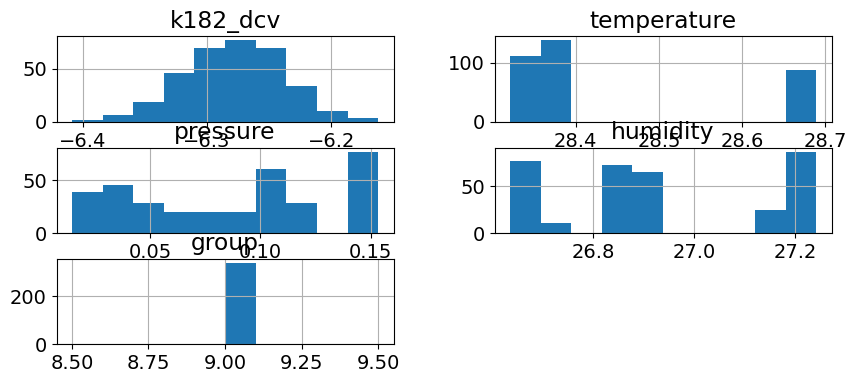

In [20]:
sample = k182_rel_data_cut[(k182_rel_data_cut.group == 9) & ((k182_rel_data_cut.dut_neg_lead == 'D4910avg') | (k182_rel_data_cut.dut_pos_lead == 'D4910avg')) & ((k182_rel_data_cut.dut_neg_lead == 'F7001bat') | (k182_rel_data_cut.dut_pos_lead == 'F7001bat'))].copy()
sample[sample.dut_pos_lead == 'F7001bat'].hist()
sample['sign'] = (sample.k182_dcv / sample.k182_dcv.abs())
res = sample.groupby(['dut_neg_lead', 'dut_pos_lead']).agg({'sign': 'unique'})
res['sign_length'] = res['sign'].apply(lambda r: len(r))
display(sample[(sample.dut_pos_lead == 'F7001bat') & (sample.k182_dcv < 0)])
display(sample[(sample.dut_pos_lead == 'F7001bat') & (sample.k182_dcv > 0)])
display(sample[(sample.dut_neg_lead == 'F7001bat') & (sample.k182_dcv < 0)])
display(sample[(sample.dut_neg_lead == 'F7001bat') & (sample.k182_dcv > 0)])